# BMS vs DMS Overlapped Gene Variants Analysis

In [1]:
# imports
import os
import sys
import glob
import operator
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
from adjustText import adjust_text
from scipy.stats import spearmanr
import polars as pl
from Bio.PDB import PDBParser
from pycytominer.feature_select import feature_select
from matplotlib.colors import Normalize

# from sklearn.cluster import AgglomerativeClustering

sns.set_style(style='white')
sys.path.append("../../..")
from utils import *
# from utils import inverse_normal_transform
clinvar_color_map = palette_dict["clinvar_clnsig_clean"]

# METADATA_INPUT = "../../../../1_allele_collection/1_inputs"
FEAT_SETS = ["GFP", "DNA", "Mito", "AGP", "Morph"]
# # Original cell imaging profiles
CLASS_RES_OUTDIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"
BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

# INTEGRATIVE_INPUT = "../../../../3_integrated_assay_analyses/1_inputs/imaging"
# GFP_MISLOCAL_FEAT_LENIENT = "Altered_95th_perc_both_batches_GFP"
# BATCH_LIST_DICT = {
#     # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
#     # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
#     # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
#     # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
#     "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
#     "2025_01_28_Batch_14": "2025_01_Batch_13-14",
#     # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
#     # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
# }

## 1. Overlapped Variants Info

In [2]:
pillar_clinvar_df = pl.read_csv(
    "../../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_wspliceAI_gold_standards_expanded_082825.csv",
    infer_schema_length=100000000
)
pillar_clinvar_single_aa_df = pl.read_csv(
    "../../../../1_allele_collection/3_outputs/pillar_snp_alleles.tsv",
    infer_schema_length=1000000, separator="\t"
)

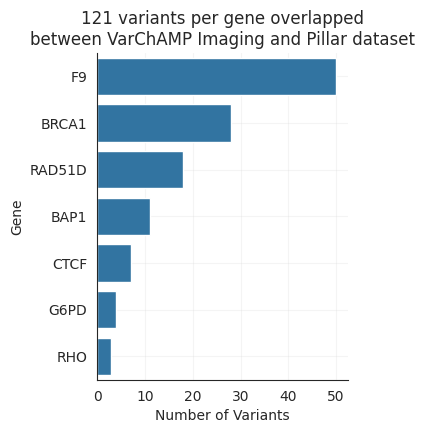

In [3]:
imaging_summary_clinvar = pl.read_csv("../../3_outputs/2_results_summary/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
imaging_summary_clinvar_pillar_snp_match_df = imaging_summary_clinvar.join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
)
imaging_summary_clinvar_pillar_snp_match_df.unique("gene_allele").shape

g = sns.catplot(data=imaging_summary_clinvar_pillar_snp_match_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)
g.ax.grid(alpha=.2)
plt.title(f"{imaging_summary_clinvar_pillar_snp_match_df.unique('gene_allele').shape[0]} variants per gene overlapped\nbetween VarChAMP Imaging and Pillar dataset")
plt.show()

In [4]:
CLASS_RES_DIR_TEMP = "../../2_analyses/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_analyses/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"
class_metric_df_gfp_adj = pl.DataFrame()
for bio_batch, batch_ids in BIO_REP_BATCHES_DICT.items():
    class_metric_df_per_bio = pl.DataFrame()
    for batch in batch_ids:
        class_metric_df = pl.read_csv(f"{CLASS_RES_DIR_TEMP.format(batch_id=batch)}/metrics_gfp_adj.csv")#.to_pandas()
        class_metric_df_per_bio = pl.concat([class_metric_df_per_bio, class_metric_df])
    class_metric_df_per_bio_allele = class_metric_df_per_bio.select(
        "AUROC", "AUPRC", "allele_0", "allele_1"
    ).group_by(
        "allele_0", "allele_1"
    ).agg(
        pl.mean("AUROC").alias("mean_AUROC"),
        pl.mean("AUPRC").alias("mean_AUPRC")
    ).rename(
        {
            "allele_0": "gene_allele",
            "mean_AUROC": f"GFP_corrected_mean_AUROC",
            "mean_AUPRC": f"GFP_corrected_mean_AUPRC"
        }
    )
    # display(class_metric_df_per_bio_allele)
    class_metric_df_gfp_adj = pl.concat([class_metric_df_gfp_adj, class_metric_df_per_bio_allele])

# with pl.Config(set_tbl_rows=100):
#     display(
#         class_metric_df_gfp_adj.sort("GFP_corrected_mean_AUROC", descending=True).filter(pl.col("gene_allele").str.contains("F9"))
#     )

In [5]:
imaging_summary_clinvar_pillar_snp_match_df.join(
    class_metric_df_gfp_adj, 
    on="gene_allele", 
    how="left"
).filter(
    pl.col("Gene")=="F9"
).with_columns(
    pl.col("GFP_corrected_mean_AUROC").fill_null(pl.col("AUROC_Mean_GFP"))
).unique("gene_allele").select(
    "gene_allele","GFP_corrected_mean_AUROC","AUROC_Mean_GFP", "Altered_95th_perc_both_batches_GFP"
).sort("AUROC_Mean_GFP", descending=True)

gene_allele,GFP_corrected_mean_AUROC,AUROC_Mean_GFP,Altered_95th_perc_both_batches_GFP
str,f64,f64,bool
"""F9_Cys28Arg""",0.965787,0.98206,true
"""F9_Pro333Leu""",0.974087,0.980512,null
"""F9_Ile316Thr""",0.971232,0.975052,null
"""F9_Arg294Gln""",0.959791,0.964782,true
"""F9_Cys335Tyr""",0.969907,0.964189,false
…,…,…,…
"""F9_Arg3His""",0.57101,0.578554,false
"""F9_Gly442Arg""",0.595722,0.577483,false
"""F9_Arg75Gln""",0.55324,0.56392,false


In [6]:
imaging_summary_clinvar.filter(
    pl.col("Gene")=="F9"
).sort("AUROC_Mean_GFP", descending=True)["gene_allele","AUROC_Mean_GFP","U2OS_abun_t_stat","U2OS_abun_t_pval"]

gene_allele,AUROC_Mean_GFP,U2OS_abun_t_stat,U2OS_abun_t_pval
str,f64,f64,f64
"""F9_Cys28Arg""",0.98206,-15.200295,0.000001
"""F9_Pro333Leu""",0.980512,3.78958,0.006807
"""F9_Ile316Thr""",0.975052,5.600629,0.000815
"""F9_Arg294Gln""",0.964782,3.697747,0.007678
"""F9_Cys335Tyr""",0.964189,4.567866,0.002581
…,…,…,…
"""F9_Arg3His""",0.578554,0.89911,0.398466
"""F9_Gly442Arg""",0.577483,-0.322046,0.756822
"""F9_Arg75Gln""",0.56392,2.179598,0.06568


In [7]:
## select key cols for output
imaging_summary_clinvar_pillar_snp_match_df_non_null = imaging_summary_clinvar_pillar_snp_match_df.select([
    col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
    if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
]).join(
    class_metric_df_gfp_adj, on="gene_allele", how="left"
).with_columns(
    pl.col("GFP_corrected_mean_AUROC").fill_null(pl.col("AUROC_Mean_GFP"))
)

# imaging_summary_clinvar_pillar_snp_match_df_non_null = imaging_summary_clinvar_pillar_snp_match_df.select(
#     ["Gene","gene_allele","clinvar_clnsig_clean"]+\
#     [f"AUROC_Mean_{feat}" for feat in FEAT_SETS]+["GFP_corrected_mean_AUROC"]+\
#     [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS]+\
#     [c for c in imaging_summary_clinvar_pillar_snp_match_df.columns if "U2OS_" in c]+\
#     [c for c in pillar_clinvar_single_aa_df.columns if c in imaging_summary_clinvar_pillar_snp_match_df.columns and c not in ["Gene","gene_allele"]]
# )

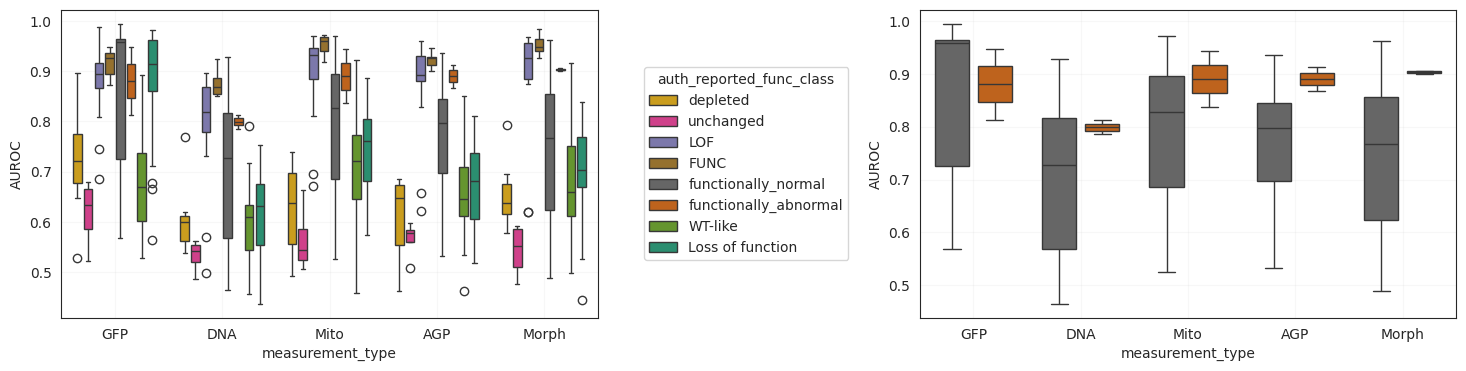

In [9]:
fig, axes = plt.subplots(1,2,figsize=(18,4))
color_palette = dict(zip(
    imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].drop_nulls().sort().unique(),
    sns.color_palette("Dark2")[:len(imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].drop_nulls().unique())]
))

sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[0],
    legend=True
)
axes[0].legend(loc="center right", bbox_to_anchor=(1.48,0.5), title="auth_reported_func_class")
sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.filter(
        pl.col("Dataset").str.contains("_unpublished")
    ).select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[1],
    legend=False
)
for ax in axes:
    ax.grid(alpha=.15)
plt.subplots_adjust(wspace=.6)
plt.show()

In [8]:
## some files from the 1% manuscript github repo
# feat_df = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/feat_importance_gt1e-3_all_alleles.csv")
# sc_profile_feat_orig = pl.read_parquet(
#     "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc.parquet")
# ref_var_cell_all_prof_df = pl.read_parquet(
#     "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc_int_featselect.parquet"
# )
# batch_profile_dir = "../1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles"

batch_profile_dir = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles"
sc_profile_feat_orig_b1314 = pl.concat([
    pl.read_parquet(f"{batch_profile_dir}/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier.parquet"),
    pl.read_parquet(f"{batch_profile_dir}/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier.parquet")
], how="diagonal")
sc_profile_feat_orig_b1314 = sc_profile_feat_orig_b1314.with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

sc_profile_feat_filtcells_b1314 = pl.concat([
    pl.read_parquet(f"{batch_profile_dir}/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"),
    pl.read_parquet(f"{batch_profile_dir}/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet")
], how="diagonal")
sc_profile_feat_filtcells_b1314 = sc_profile_feat_filtcells_b1314.with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
).select([
    "Metadata_CellID"
])

batch_profile_filtcells_dir = "/home/shenrunx/igvf/varchamp/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_results"
sc_profile_feat_filtcells_gfp_corr_b1314 = pl.concat([
    pl.read_parquet(f"{batch_profile_filtcells_dir}/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/gfp_adj_filtered_cells_profiles.parquet"),
    pl.read_parquet(f"{batch_profile_filtcells_dir}/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/gfp_adj_filtered_cells_profiles.parquet")
], how="diagonal")
sc_profile_feat_filtcells_gfp_corr_b1314 = sc_profile_feat_filtcells_gfp_corr_b1314.with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
).select([
    "Metadata_CellID",
    "Metadata_gene_allele",
    "Metadata_Well",
    "Metadata_Plate",
    "Metadata_refvar_gfp_adj_classify"
])

normalized_sc_profiles_b1314 = sc_profile_feat_filtcells_b1314.join(sc_profile_feat_orig_b1314, on="Metadata_CellID", how="inner")

In [9]:
SM_CLASS_RES_DIR = "../1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_results/{batch_id}//"
FEAT = "GFP"
feat_import_df_feat = pl.DataFrame()

## select all feat with importance > 1e-3
importance_thres = 1e-3
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
    ## ONLY grep the allele come from the bio-rep
    allele_batch_df = imaging_summary_clinvar.filter(pl.col("Metadata_Bio_Batch")==bio_rep)
    batch_allele_list = list(allele_batch_df["gene_allele"]) + list(allele_batch_df["symbol"].unique())
    for batch_id in bio_rep_batches:
        # Read the data
        feat_df_b = pl.scan_csv(f"{batch_profile_filtcells_dir}/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/feat_importance_gfp_adj.csv")
        meta_cols = [c for c in feat_df_b.collect_schema().names() if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
        feat_cols = [c for c in feat_df_b.collect_schema().names() if c not in meta_cols and FEAT in c]
        feat_df_batch = feat_df_b.with_columns(
            [pl.col(c).cast(pl.Float64, strict=False).alias(c) for c in feat_cols]
        ).with_columns(
            pl.lit(batch_id).alias("Metadata_Batch"),
            pl.col("Group2").str.split('_').list.slice(-2).list.join("_").alias("Metadata_gene_allele")
       ).filter(
            (pl.col("Metadata_Feature_Type")==FEAT)&(~pl.col("Metadata_Control"))
            &(pl.col("Group1").is_in(batch_allele_list)|(pl.col("Metadata_gene_allele").is_in(batch_allele_list)))
        ).select(meta_cols + feat_cols + ["Metadata_Batch", "Metadata_gene_allele"])
        feat_import_df_feat = pl.concat([feat_import_df_feat, feat_df_batch.collect()], how="diagonal")
        
# feat_import_df_feat["Metadata_gene_allele"]

In [10]:
feat_df = pl.DataFrame()

for j, allele in tqdm(imaging_summary_clinvar.to_pandas().iterrows()):
    batch_list = list(feat_import_df_feat.filter(
        pl.col("Metadata_gene_allele")==allele["gene_allele"]
    ).unique("Metadata_Batch")["Metadata_Batch"])
    allele_df = pl.DataFrame()
    for i, batch in enumerate(batch_list):
        batch_df = feat_import_df_feat.filter(
            (pl.col("Metadata_Batch")==batch)&(pl.col("Metadata_gene_allele")==allele["gene_allele"])
        )
        feat_cols = [col for col in batch_df.columns if "Metadata" not in col and "Group" not in col]
        batch_df = batch_df.filter(
            ~pl.all_horizontal(pl.col(feat_cols).is_null())
        )
        non_null_gfp = [col for col in feat_cols if not batch_df[col].is_null().any()]
        batch_df_col = (
            batch_df.select(non_null_gfp).mean()
           .transpose(include_header=True)
           .filter(pl.col("column_0") > importance_thres)
           .sort("column_0", descending=True)
           # .head(top_num)#["column"]
           # .to_list()
        )
        if not allele_df.is_empty():
            allele_df = allele_df.join(
                batch_df_col.with_columns(
                    pl.col("column_0").alias(batch),
                    pl.col("column").alias("index"),
                ).select("index", batch),
                on="index",
                how="full",
                coalesce=True
            )
        else:
            allele_df = batch_df_col.with_columns(
                pl.col("column_0").alias(batch),
                pl.col("column").alias("index"),
            ).select("index", batch)
            
    if allele_df.is_empty():
        continue

    allele_df = allele_df.with_columns(
        pl.mean_horizontal(pl.col([col for col in allele_df.columns if "Batch" in col])).alias("feat_importance"),
        pl.col("index").alias("cp_feature")
    ).select(
        pl.col(["cp_feature", "feat_importance"])
    ).rename(
        {"feat_importance": allele["gene_allele"]}
    )

    if not feat_df.is_empty():
        feat_df = feat_df.join(
            allele_df,
            left_on="cp_feature",
            right_on="cp_feature",
            how="full",
            coalesce=True
        )
    else:
        feat_df = allele_df

291it [00:46,  6.21it/s]


## 2. Gene by Gene Analyses

### F9

In [11]:
# import matplotlib.patches as mpatches
clinvar_category = ['1_Pathogenic', '2_Benign', '3_Conflicting', '4_VUS', '5_Others']
clinvar_palette_clinvar = sns.color_palette("Set2")
clinvar_palette_clinvar[0], clinvar_palette_clinvar[1], clinvar_palette_clinvar[2], clinvar_palette_clinvar[3], clinvar_palette_clinvar[4], clinvar_palette_clinvar[5], clinvar_palette_clinvar[7] = \
clinvar_palette_clinvar[1], clinvar_palette_clinvar[4], clinvar_palette_clinvar[3], clinvar_palette_clinvar[2], clinvar_palette_clinvar[7], clinvar_palette_clinvar[7], clinvar_palette_clinvar[5]
palette_dict = {
    "clinvar_clnsig_clean": dict(zip(clinvar_category, clinvar_palette_clinvar[:7]))
}
# # Extract colors and labels
# colors = palette_dict["clinvar_clnsig_clean"]

# # Create legend handles
# legend_elements = [mpatches.Patch(color=color, label=label.replace('_', ' ').replace('1 ', '').replace('2 ', '').replace('3 ', '').replace('4 ', '').replace('5 ', '').replace('6 ', '')) 
#                  for label, color in colors.items()]

# # Create legend
# plt.legend(handles=legend_elements, title='ClinVar Classification', 
#          bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


<Figure size 640x480 with 0 Axes>

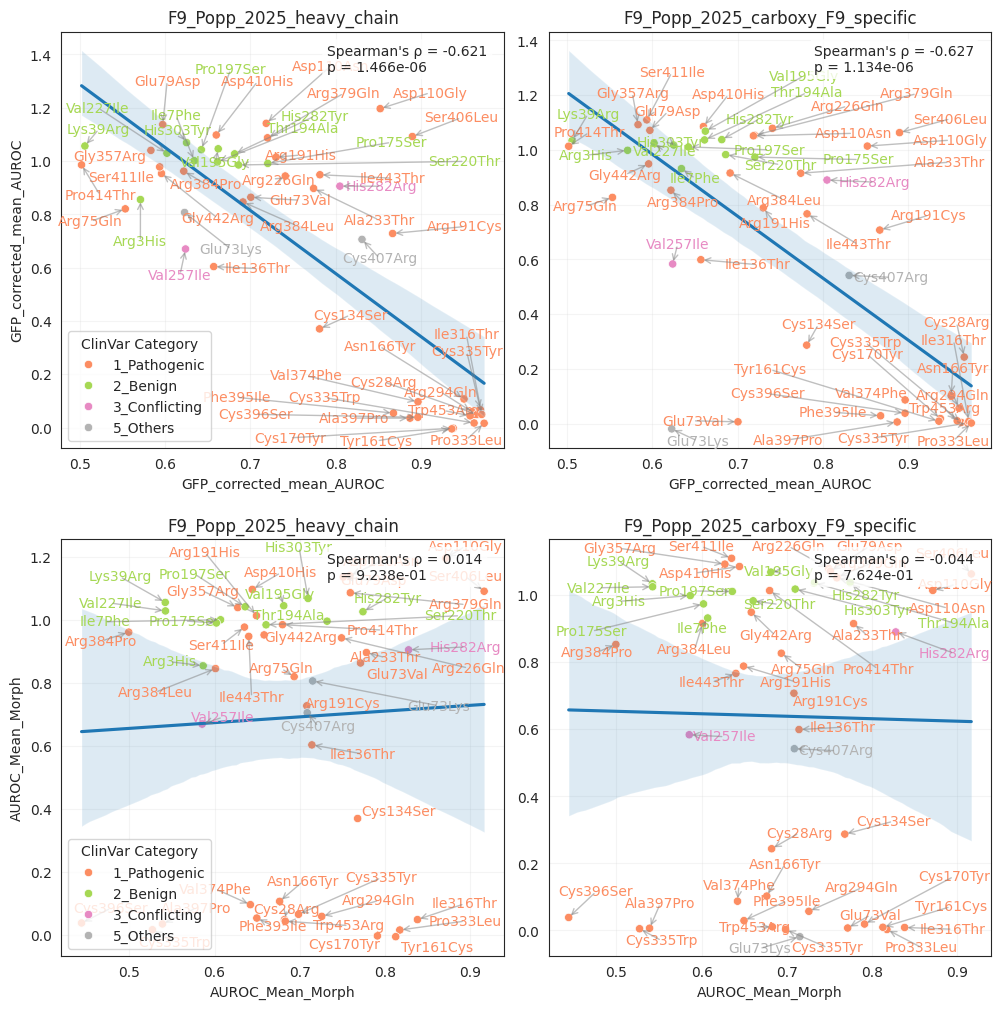

In [12]:
gene = "F9"
imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df_non_null.filter(
    pl.col("Gene")==gene
)
studies_on_gene = [
    'F9_Popp_2025_heavy_chain',
    'F9_Popp_2025_carboxy_F9_specific',
#  'F9_Popp_2025_carboxy_gla_motif',
#  'F9_Popp_2025_strep_2',
#  'F9_Popp_2025_light_chain'
]

#[x for x in imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list() if "_model" not in x]
unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()

plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(12, 12)) ##sharey=True, 
for j, study in enumerate(studies_on_gene):
    if "heavy" not in study and "specific" not in study:
        continue
    imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
        pl.col("Dataset")==study
    )
    imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.with_columns(
        pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
    )
    for i, feat in enumerate(["GFP","Morph"]):
        if feat == "AGP" or feat == "Mito" or feat == "DNA":
            continue
        if feat == "GFP":
            feat = "GFP_corrected_mean_AUROC"
        else:
            feat = f"AUROC_Mean_{feat}"
            
        sns.scatterplot(
            data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
                pl.col("auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
                # pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
            ).to_pandas(),
            x=feat,
            y="auth_reported_score",
            ax=axes[i, j],
            hue="clinvar_clnsig_clean",
        #    style=f"Altered_95th_perc_both_batches_{feat}",
            palette=palette_dict["clinvar_clnsig_clean"],
            hue_order=sorted(imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
                pl.col("auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
                # pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
            )["clinvar_clnsig_clean"].unique().to_list())
        )
        axes[i, j].legend(fontsize=10, loc="lower left", title="ClinVar Category")
        if j != 0:
            axes[i, j].get_legend().remove()
        sns.regplot(
            data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
            x=feat,
            y="auth_reported_score",
            ax=axes[i, j],
            scatter=False
        )
        # Get pandas dataframe for easier indexing
        plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
        # Add point labels with adjustText
        texts = []
        for idx, row in plot_data.iterrows():
            if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[feat])):
                text = axes[i, j].annotate(
                    row["gene_allele"].split('_')[-1],
                    (row[feat], row["auth_reported_score"]),
                    fontsize=10,
                    color=palette_dict["clinvar_clnsig_clean"][row["clinvar_clnsig_clean"]]
                )
                texts.append(text)
        # adjust_text(texts, ax=axes[i, j], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
        adjust_text(
            texts,
            ax=axes[i, j],
            arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
            expand_text=(1.2, 1.4),
            expand_points=(1.2, 1.4),
            force_text=(0.5, 0.5),
            force_points=(0.5, 0.5),
            lim=200  # Increase from default (100)
        )
        # Calculate Spearman correlation
        mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[feat]))
        rho, p_val = spearmanr(
            plot_data["auth_reported_score"][mask], 
            plot_data[feat][mask]
        )

        # Add correlation text to plot
        axes[i, j].text(
            0.6, 0.97, 
            f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
            fontsize=10,
            transform=axes[i, j].transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
        if j == 0:
            axes[i, j].set_ylabel(feat)
        else:
            axes[i, j].set_ylabel("")
        axes[i, j].set_title(study)
        axes[i, j].grid(alpha=.2)
       
plt.subplots_adjust(wspace=0.1, hspace=0.22)
plt.show()

In [ ]:
ref_var_cell_all_prof_df_f9 = ref_var_cell_all_prof_df.filter(
    (pl.col("Metadata_gene_allele").is_in(sorted_unique_variants)) | (pl.col("Metadata_gene_allele")=="F9")
)
ref_var_cell_all_prof_df_f9_var = ref_var_cell_all_prof_df_f9.group_by(
    "Metadata_gene_allele", "Metadata_Plate", "Metadata_Well"
).agg(
    pl.median([f for f in ref_var_cell_all_prof_df_f9.columns if "Metadata" not in f])
).group_by(
    "Metadata_gene_allele"
).agg(
    pl.median([f for f in ref_var_cell_all_prof_df_f9.columns if "Metadata" not in f])
)

ref_var_cell_all_prof_df_f9_var = inverse_normal_transform(ref_var_cell_all_prof_df_f9_var)
ref_var_cell_all_prof_df_f9_var = feature_select(ref_var_cell_all_prof_df_f9_var.to_pandas(), operation="variance_threshold")
ref_var_cell_all_prof_df_f9_var = feature_select(ref_var_cell_all_prof_df_f9_var, operation="correlation_threshold", corr_threshold=0.9).set_index("Metadata_gene_allele")
ref_var_cell_all_prof_df_f9_var = ref_var_cell_all_prof_df_f9_var[[feat for feat in ref_var_cell_all_prof_df_f9_var.columns if "Metadata" not in feat]].reset_index() ##[feat for feat in feat_df["cp_feature"] if feat in norm_vars_feat_sel_df.columns]
# sns.clustermap(
#     data=ref_var_cell_all_prof_df_f9_var.set_index("Metadata_gene_allele")[[f for f in ref_var_cell_all_prof_df_f9_var.columns if "Intensity" in f and "GFP" in f]],
#     cmap="vlag", center=0,
#     figsize=(20,15),
#     yticklabels=1
# )
# plt.show()

## 3. Feature Analyses

In [14]:
# def create_spearman_heatmap(df, figsize=(12, 10)):
#     """
#     Create a Spearman correlation heatmap with significance annotations (lower triangle only)
    
#     Parameters:
#     df: polars DataFrame with numeric columns to correlate
#     figsize: tuple for figure size
#     """
    
#     # Get numeric columns (exclude gene_allele or any string columns)
#     numeric_columns = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]]
    
#     # Convert to pandas for easier correlation calculation
#     df_numeric = df.select(numeric_columns).to_pandas()
    
#     # Calculate Spearman correlation matrix and p-values
#     n_vars = len(numeric_columns)
#     corr_matrix = np.zeros((n_vars, n_vars))
#     p_matrix = np.zeros((n_vars, n_vars))
    
#     for i in range(n_vars):
#         for j in range(n_vars):
#             if i == j:
#                 corr_matrix[i, j] = 1.0
#                 p_matrix[i, j] = 0.0
#             else:
#                 corr, p_val = spearmanr(df_numeric.iloc[:, i], df_numeric.iloc[:, j])
#                 corr_matrix[i, j] = corr
#                 p_matrix[i, j] = p_val
    
#     # Create significance annotation matrix
#     sig_matrix = np.zeros_like(p_matrix, dtype=object)
#     for i in range(n_vars):
#         for j in range(n_vars):
#             if p_matrix[i, j] < 0.001:
#                 sig_matrix[i, j] = '***'
#             elif p_matrix[i, j] < 0.01:
#                 sig_matrix[i, j] = '**'
#             elif p_matrix[i, j] < 0.05:
#                 sig_matrix[i, j] = '*'
#             else:
#                 sig_matrix[i, j] = ''
    
#     # Create mask for upper triangle (hide upper triangle, keep lower triangle + diagonal)
#     mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    
#     # Create annotations combining correlation values and significance
#     annot_matrix = np.zeros_like(corr_matrix, dtype=object)
#     for i in range(n_vars):
#         for j in range(n_vars):
#             if mask[i, j]:  # Skip upper triangle
#                 annot_matrix[i, j] = ""
#             else:
#                 corr_val = f"{corr_matrix[i, j]:.3f}"
#                 sig_val = sig_matrix[i, j]
#                 annot_matrix[i, j] = f"{corr_val}\n{sig_val}" if sig_val else corr_val
    
#     # Create the plot
#     fig, ax = plt.subplots(figsize=figsize)
    
#     # Create heatmap with mask to show only lower triangle
#     sns.heatmap(corr_matrix, 
#                 annot=annot_matrix, 
#                 fmt='', 
#                 cmap='RdBu_r', 
#                 center=0,
#                 vmin=-1, 
#                 vmax=1,
#                 square=True,
#                 mask=mask,
#                 xticklabels=[col.replace('_', ' ').replace('F9 Popp 2025 ', '') for col in numeric_columns],
#                 yticklabels=[col.replace('_', ' ').replace('F9 Popp 2025 ', '') for col in numeric_columns],
#                 cbar_kws={'label': 'Spearman Correlation Coefficient', 'shrink': 0.8},
#                 annot_kws={'fontsize': 11, 'ha': 'center', 'va': 'center'})
    
#     # Customize the plot
#     plt.title('Spearman Correlation Matrix\nwith Significance Levels (Lower Triangle)', fontsize=16, fontweight='bold', pad=20)
#     plt.xlabel('Features', fontsize=12, fontweight='bold')
#     plt.ylabel('Features', fontsize=12, fontweight='bold')
    
#     # Rotate x-axis labels for better readability
#     plt.xticks(rotation=45, ha='right')
#     plt.yticks(rotation=0)
    
#     # Add legend for significance levels
#     legend_text = "Significance levels:\n* p < 0.05\n** p < 0.01\n*** p < 0.001"
#     plt.figtext(0.02, 0.98, legend_text, fontsize=10, verticalalignment='top',
#                 bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
#     # Add sample size information
#     n_samples = len(df)
#     sample_text = f"n = {n_samples} samples"
#     plt.figtext(0.98, 0.02, sample_text, fontsize=10, ha='right',
#                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
#     plt.tight_layout()
#     return fig, ax, corr_matrix, p_matrix


# # Your original usage code
# df = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
#     ~pl.col("Dataset").str.contains("_model")
# ).pivot(
#     "Dataset",
#     index=["gene_allele"]+[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
#     values="auth_reported_score",
# )

# # Create heatmap (now shows only lower triangle)
# fig, ax, corr_matrix, p_matrix = create_spearman_heatmap(df)
# plt.show()

50


<Figure size 640x480 with 0 Axes>

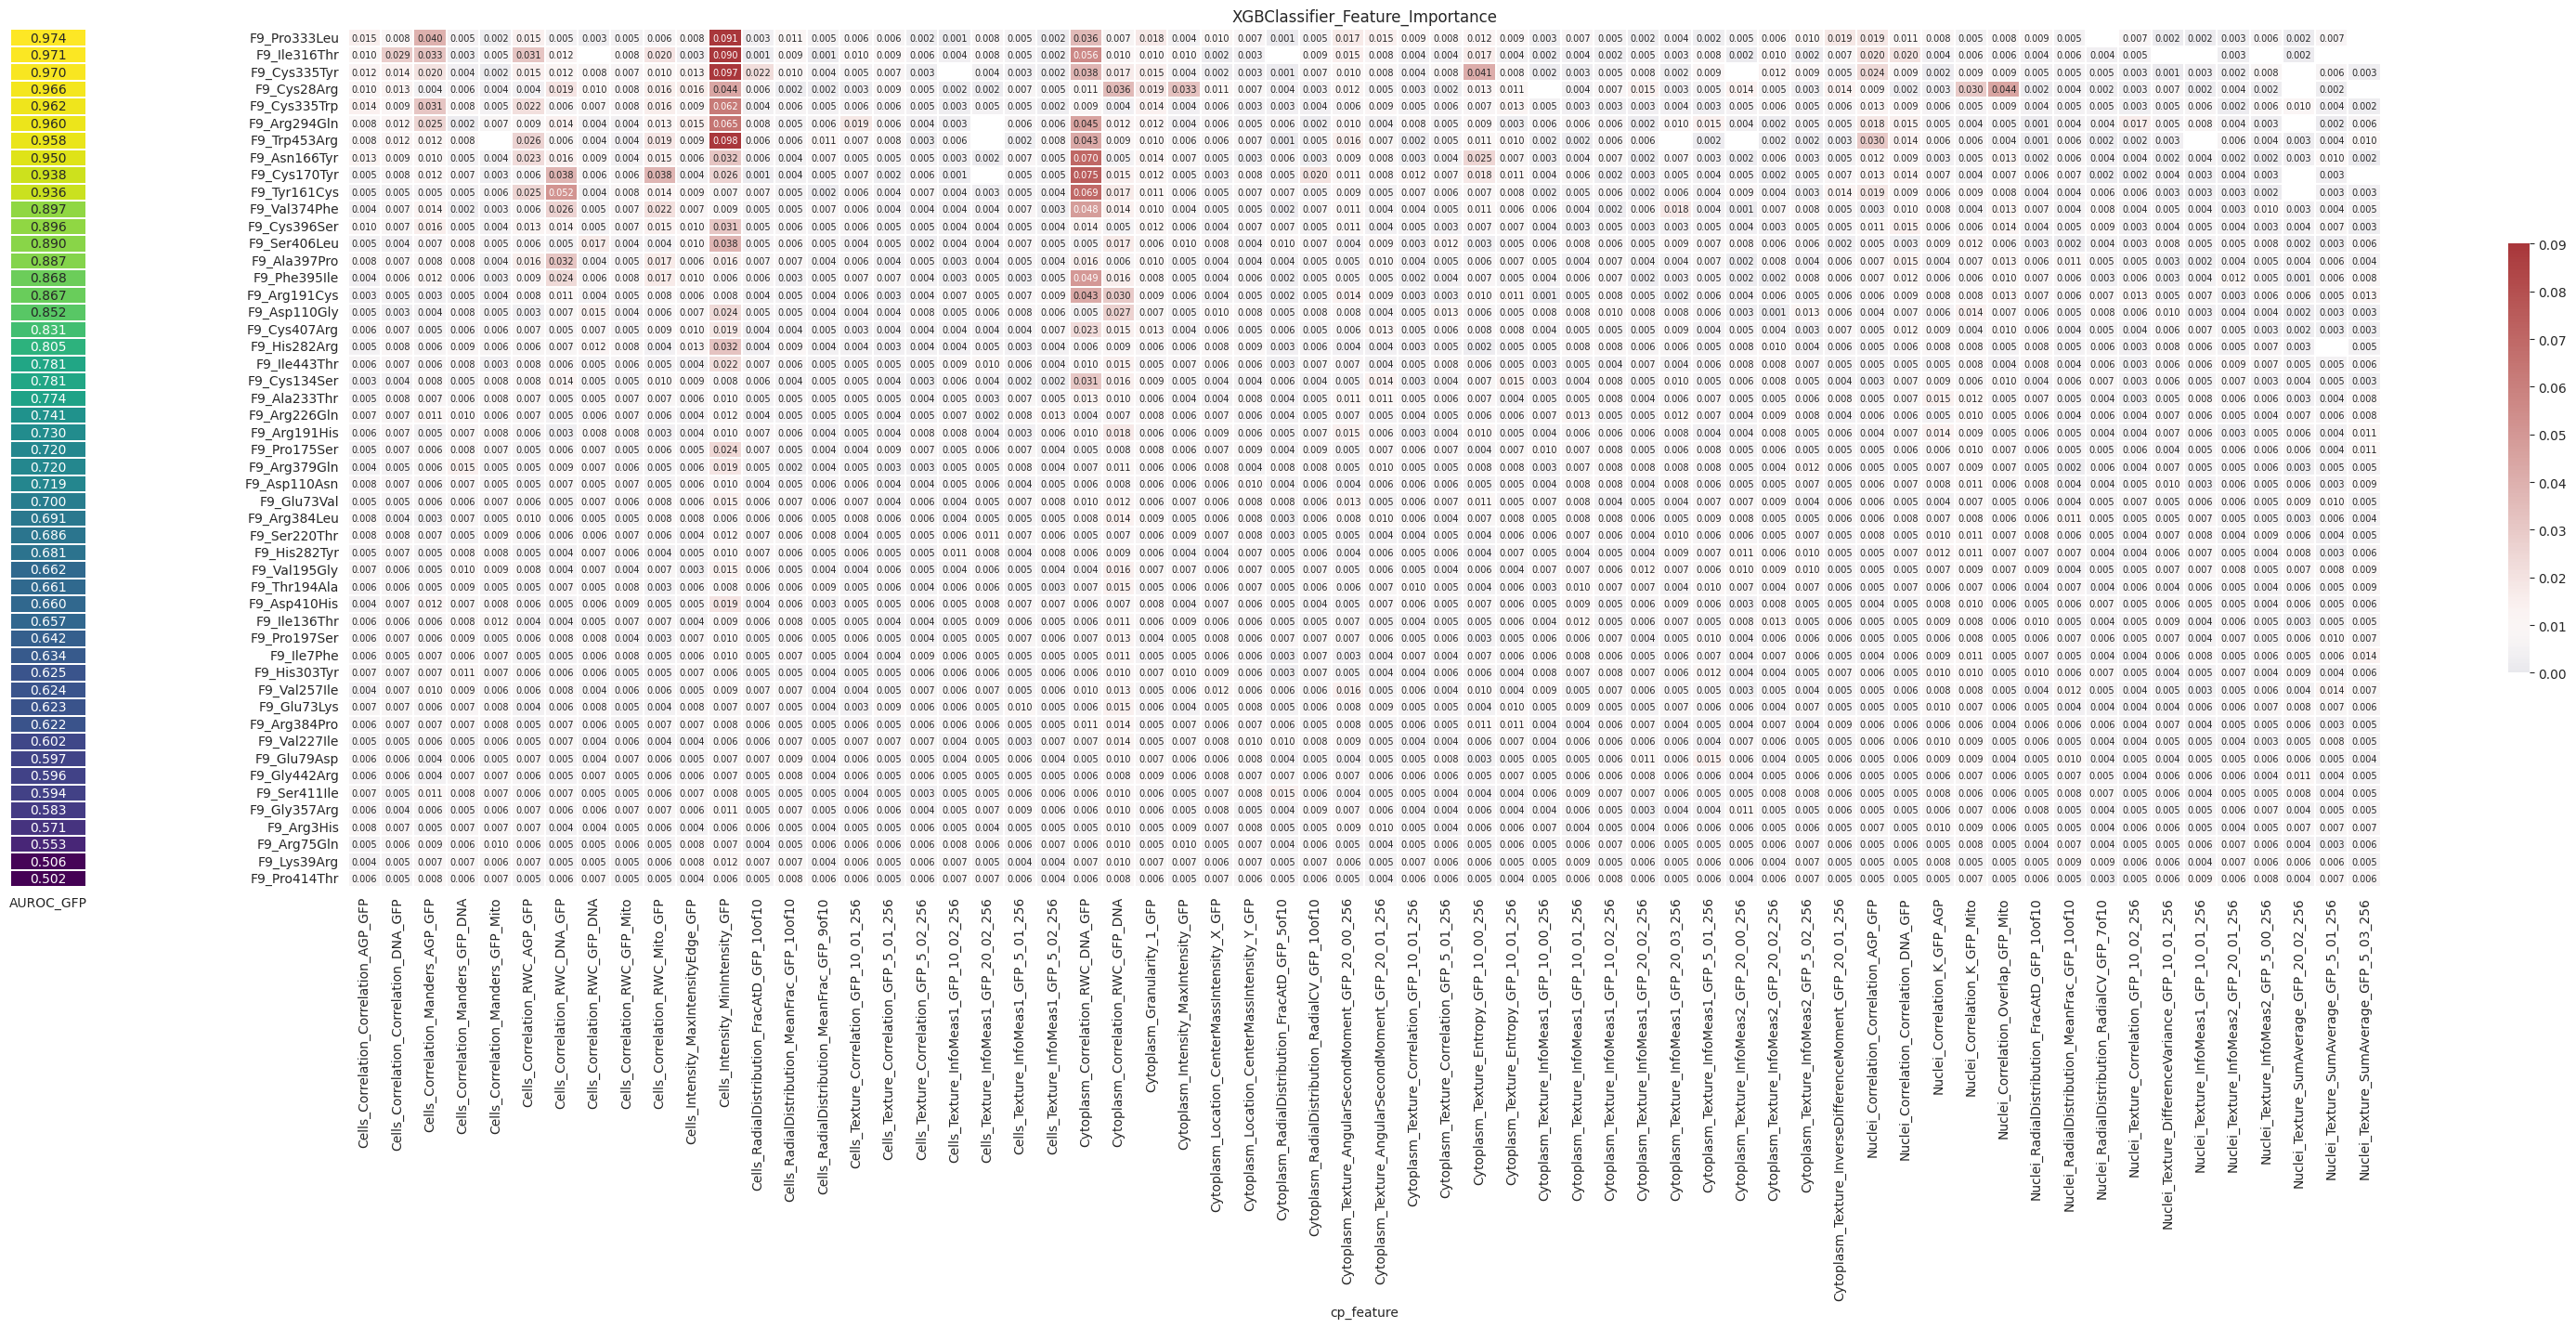

In [16]:
sorted_unique_variants = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele").sort(
    "GFP_corrected_mean_AUROC", descending=True
)["gene_allele"].to_list()
sorted_unique_variants = [var for var in sorted_unique_variants if var in feat_df.columns]
print(len(sorted_unique_variants))

## grep the top features to look at
# get_top_feats = feat_df[["cp_feature"]+[idx for idx in feat_df.columns if gene in idx]].with_columns(
#     pl.mean_horizontal(
#         pl.col(sorted_unique_variants)
#     ).alias('row_mean')
# ).sort(sorted_unique_variants, descending=True)["cp_feature"].to_list()[-10:][::-1]

## get the features with max_feat_importance > 0.015 in any GENE variant
# get_top_feats = feat_df.with_columns(
#     pl.mean_horizontal(
#         pl.col(sorted_unique_variants)
#     ).alias('row_mean')
# ).select(
#     ["cp_feature","row_mean"]+[idx for idx in feat_df.columns if gene in idx]
# ).filter(
#    pl.max_horizontal(sorted_unique_variants) > .015 #0.015
# ).sort("row_mean", descending=True)["cp_feature"].to_list()

your_score_array = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele").sort(
    "GFP_corrected_mean_AUROC", descending=True
)["GFP_corrected_mean_AUROC"].to_numpy()

TOP_FEAT_NUM = 5
all_features = feat_df.select("cp_feature").unique().sort("cp_feature")
# Get top 10 for each variant with feature names
top_10_dfs = []
for col in sorted_unique_variants:
    top_10 = feat_df.filter(
        pl.col(col).is_in(pl.col(col).top_k(TOP_FEAT_NUM))
    ).select(["cp_feature", col])
    top_10_dfs.append(top_10)

# Start with all features and left join each variant's top 10
result_df = all_features
for i, col in enumerate(sorted_unique_variants):
    result_df = result_df.join(top_10_dfs[i], on="cp_feature", how="left")

subset_df = result_df.select(
    ["cp_feature"] + sorted_unique_variants
).filter(
    ~pl.all_horizontal(pl.all().exclude("cp_feature").is_null())
)
get_top_feats = subset_df["cp_feature"].to_list()

plt.clf()
fig = plt.figure(figsize=(40, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[0.03, 1], wspace=.2)

# Left side: score bar
ax_left = fig.add_subplot(gs[:, 0])
score_data = your_score_array.reshape(-1, 1)
sns.heatmap(score_data, ax=ax_left, annot=True, cbar=False, cmap="viridis", 
            yticklabels=False, xticklabels=['AUROC_GFP'], fmt='.3f', linewidth=.1)

# Main heatmap
ax_main = fig.add_subplot(gs[:, 1])
sns.heatmap(
  data=feat_df.to_pandas().set_index("cp_feature").loc[get_top_feats,sorted_unique_variants].T,
  ax=ax_main,
  cmap="vlag",
    center=0.01, vmin=0, vmax=0.09,
  cbar_kws={"shrink": 0.5},
    yticklabels=1,
    xticklabels=1, linewidth=.1,
    annot=True, fmt='.3f',annot_kws={"fontsize":7},
)
ax_main.set_ylabel('')
ax_main.set_title("XGBClassifier_Feature_Importance")
plt.show()

In [63]:
ref_var_cell_all_prof_df = normalized_sc_profiles_b1314
norm_vars_feat_df, norm_var_sc_feat_df = pl.DataFrame(), pl.DataFrame()
sig_diff_feat = [feat for feat in ref_var_cell_all_prof_df.columns if "Metadata" not in feat and "GFP" in feat] #[feat for feat in get_top_feats if feat in ref_var_cell_all_prof_df.columns]

for gene in tqdm(["F9"]):
    gene_mean = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==gene).select(sig_diff_feat).mean().to_numpy()[0].tolist()
    gene_std = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==gene).select(sig_diff_feat).std().to_numpy()[0].tolist()
    
    z_norm_var_sc_feat_df = ref_var_cell_all_prof_df.filter(
        (pl.col("Metadata_gene_allele").str.starts_with(f"{gene}_"))
        &(pl.col("Metadata_gene_allele")!=gene)
        &(pl.col("Metadata_gene_allele").is_in(imaging_summary_clinvar["gene_allele"].unique()))
    ).with_columns(
        [((pl.col(col) - pl.lit(gene_mean[i])) / pl.lit(gene_std[i])).alias(col)
        for i, col in enumerate(sig_diff_feat)]
    )
    norm_var_sc_feat_df = pl.concat([
        norm_var_sc_feat_df,
        z_norm_var_sc_feat_df
    ])
    z_norm_var_feat_df = z_norm_var_sc_feat_df.group_by(
        "Metadata_gene_allele", "Metadata_Plate", "Metadata_Well" ## aggregate by well first
    ).agg(
        pl.col(col).mean().alias(col)
        for col in sig_diff_feat
    ).group_by(
        "Metadata_gene_allele" ## aggregate by allele
    ).agg(
        pl.col(col).median().alias(col)
        for col in sig_diff_feat
    )#.to_pandas().set_index("Metadata_gene_allele")[sig_diff_feat]
    
    norm_vars_feat_df = pl.concat([norm_vars_feat_df, 
                                   z_norm_var_feat_df],
                                  how="diagonal")

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


In [78]:
norm_vars_feat_sel_df = feature_select(norm_vars_feat_df.to_pandas(), operation="variance_threshold")
norm_vars_feat_sel_df = feature_select(norm_vars_feat_sel_df, operation="correlation_threshold", corr_threshold=0.9).set_index("Metadata_gene_allele")
norm_vars_feat_sel_df = norm_vars_feat_sel_df[[feat for feat in norm_vars_feat_sel_df.columns if "Metadata" not in feat]].reset_index() ##[feat for feat in feat_df["cp_feature"] if feat in norm_vars_feat_sel_df.columns]
norm_vars_feat_sel_df.shape

(52, 100)

In [79]:
# sns.clustermap(
#     data=norm_vars_feat_sel_df.set_index("Metadata_gene_allele")[[f for f in norm_vars_feat_sel_df.columns if "Intensity" in f]],
#     cmap="vlag", center=0,
#     figsize=(20,15),
#     yticklabels=1
# )
# plt.show()

In [128]:
norm_vars_feat_meta_df = pl.DataFrame(norm_vars_feat_df).join(
    imaging_summary_clinvar_pillar_snp_match_df_gene, #.unique("gene_allele"),
    left_on="Metadata_gene_allele",
    right_on="gene_allele"
).rename(
    dict(
        zip(
            [c for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_allele"],
            [f"Metadata_{c}" for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_allele"]
        )
    )
)
norm_vars_feat_meta_df.shape

(300, 1263)

In [129]:
[c for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if "auth" in c]

norm_vars_feat_meta_df["Metadata_Dataset"].unique()

Metadata_Dataset
str
"""F9_Popp_2025_carboxy_F9_specif…"
"""F9_Popp_2025_strep_2"""
"""F9_Popp_2025_light_chain"""
"""F9_Popp_2025_model"""
"""F9_Popp_2025_carboxy_gla_motif"""
"""F9_Popp_2025_heavy_chain"""


In [110]:
[feat for feat in norm_vars_feat_meta_df.columns if "MedianIntensity" in feat]

['Cells_Intensity_MedianIntensity_GFP',
 'Nuclei_Intensity_MedianIntensity_GFP',
 'Cytoplasm_Intensity_MedianIntensity_GFP']

<Figure size 640x480 with 0 Axes>

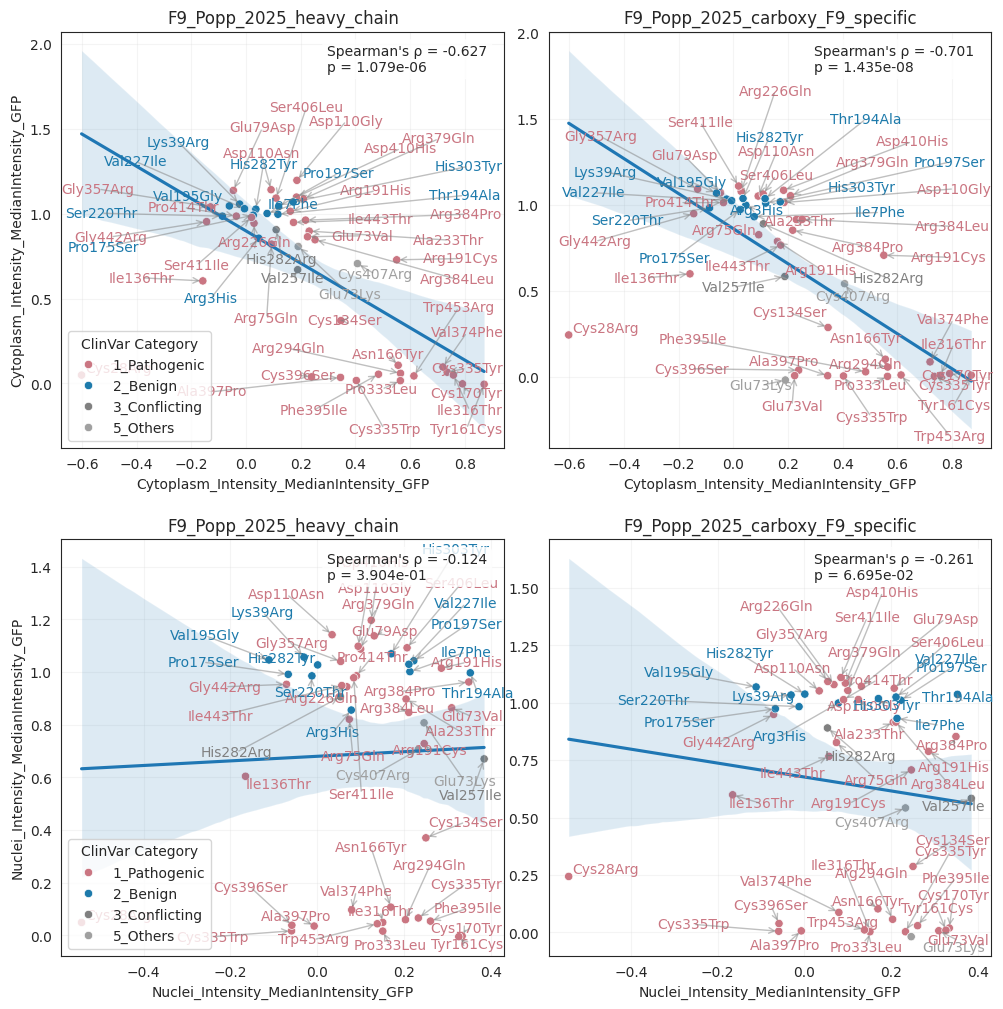

In [139]:
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(12, 12)) ##sharey=True, 
for j, study in enumerate(studies_on_gene):
    if "heavy" not in study and "specific" not in study:
        continue
    imaging_summary_clinvar_pillar_snp_match_df_gene_study = norm_vars_feat_meta_df.filter(
        pl.col("Metadata_Dataset")==study
    )
    imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.with_columns(
        pl.col("Metadata_auth_reported_score").cast(pl.Float64).alias("auth_reported_score"),
        pl.col("Metadata_clinvar_clnsig_clean").alias("clinvar_clnsig_clean"),
        pl.col("Metadata_gene_allele").alias("gene_allele")
    )
    for i, feat in enumerate(["Cytoplasm_Intensity_MedianIntensity_GFP","Nuclei_Intensity_MedianIntensity_GFP"]):
        sns.scatterplot(
            data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
                pl.col("Metadata_auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
                # pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
            ).to_pandas(),
            x=feat,
            y="auth_reported_score",
            ax=axes[i, j],
            hue="clinvar_clnsig_clean",
        #    style=f"Altered_95th_perc_both_batches_{feat}",
            palette=palette_dict["clinvar_clnsig_clean"],
            hue_order=sorted(imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
                pl.col("Metadata_auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
                # pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
            )["clinvar_clnsig_clean"].unique().to_list())
        )
        axes[i, j].legend(fontsize=10, loc="lower left", title="ClinVar Category")
        if j != 0:
            axes[i, j].get_legend().remove()
        sns.regplot(
            data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
            x=feat,
            y="auth_reported_score",
            ax=axes[i, j],
            scatter=False
        )
        # Get pandas dataframe for easier indexing
        plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
        # Add point labels with adjustText
        texts = []
        for idx, row in plot_data.iterrows():
            if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[feat])):
                text = axes[i, j].annotate(
                    row["gene_allele"].split('_')[-1],
                    (row[feat], row["auth_reported_score"]),
                    fontsize=10,
                    color=palette_dict["clinvar_clnsig_clean"][row["clinvar_clnsig_clean"]]
                )
                texts.append(text)
        # adjust_text(texts, ax=axes[i, j], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
        adjust_text(
            texts,
            ax=axes[i, j],
            arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5),
            expand_text=(1.2, 1.4),
            expand_points=(1.2, 1.4),
            force_text=(0.5, 0.5),
            force_points=(0.5, 0.5),
            lim=200  # Increase from default (100)
        )
        # Calculate Spearman correlation
        mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[feat]))
        rho, p_val = spearmanr(
            plot_data["auth_reported_score"][mask], 
            plot_data[feat][mask]
        )

        # Add correlation text to plot
        axes[i, j].text(
            0.6, 0.97, 
            f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
            fontsize=10,
            transform=axes[i, j].transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
        if j == 0:
            axes[i, j].set_ylabel(feat)
        else:
            axes[i, j].set_ylabel("")
        axes[i, j].set_title(study)
        axes[i, j].grid(alpha=.2)
       
plt.subplots_adjust(wspace=0.1, hspace=0.22)
plt.show()

In [1]:
# # Combine both color arrays as separate columns
# df = norm_vars_feat_meta_df.sort("Metadata_GFP_corrected_mean_AUROC", descending=True).to_pandas().set_index("Metadata_gene_allele").loc[:,[c for c in norm_vars_feat_meta_df.columns if "Metadata" not in c]] ## [c for c in get_top_feats if c in norm_vars_feat_meta_df.columns]
# filtered_df = df #df.loc[:,  (df.std() > 0.15)] ##(df.abs().mean() > 0.1) &

# # Create row colors - AUROC scores
# auroc_colors_series = pd.Series(norm_vars_feat_meta_df.sort("Metadata_GFP_corrected_mean_AUROC", descending=True)["Metadata_GFP_corrected_mean_AUROC"].to_numpy(), index=filtered_df.index, name='AUROC_GFP')
# norm = Normalize(vmin=auroc_colors_series.min(), vmax=auroc_colors_series.max())
# cmap = plt.cm.viridis
# auroc_colors = cmap(norm(auroc_colors_series.values))

# row_colors_df = pd.DataFrame(index=filtered_df.index)
# row_colors_df['AUROC_GFP'] = list(auroc_colors)

# col_colors_df = pd.DataFrame(index=filtered_df.columns)
# col_colors_df['Annotation'] = ["forestgreen" if "Intensity" in f else "skyblue" for f in filtered_df.columns]
# col_colors_df = col_colors_df.sort_values("Annotation")

# # Create clustermap with cluster-based ordering
# g = sns.clustermap(
#    data=filtered_df[col_colors_df.index],
#    cmap="vlag", center=0,
#    row_colors=row_colors_df,
#    col_colors=col_colors_df,
#    row_cluster=False,
#    col_cluster=False,
#    cbar_pos=(1.003, 0.5, 0.02, 0.2),
#    yticklabels=1, xticklabels=1,
#    figsize=(25, 15),
#    tree_kws={'alpha': 0},  # Make dendrogram invisible
#     linewidth=.1,
#     colors_ratio=0.03  # Controls row_colors width,
# )
# # Set tick label sizes
# # g.ax_heatmap.tick_params(axis='y', labelsize=10)  # y-axis labels
# g.ax_heatmap.tick_params(axis='x', rotation=45)  # x-axis labels
# g.fig.suptitle("GFP-Related CellProfiler features (S.D. > 0.15) Z-score Heatmap\n(Variants sorted by Cluster and GFP AUROC)", fontsize=12, y=.98)
# # Add label to main heatmap colorbar
# g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', labelpad=15)
# g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=9) # Adjust fontsize as needed
# # Get current ytick labels
# ytick_labels = g.ax_heatmap.get_yticklabels()
# # subset_variants = high_score_mask[high_score_mask].index
# # # Color the labels
# # for label in ytick_labels:
# #    variant_name = label.get_text()
# #    if variant_name in subset_variants:
# #          label.set_color('red')  # Color for subset members
# #    else:
# #          label.set_color('black')  # Default color for others

# # Add colorbar for AUROC scores
# auroc_cbar_ax = g.fig.add_axes([.15, 0.5, 0.02, 0.2])
# auroc_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=auroc_cbar_ax)
# auroc_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
# auroc_cbar.ax.yaxis.set_label_position('left')
# auroc_cbar.ax.yaxis.tick_left()

# plt.show()

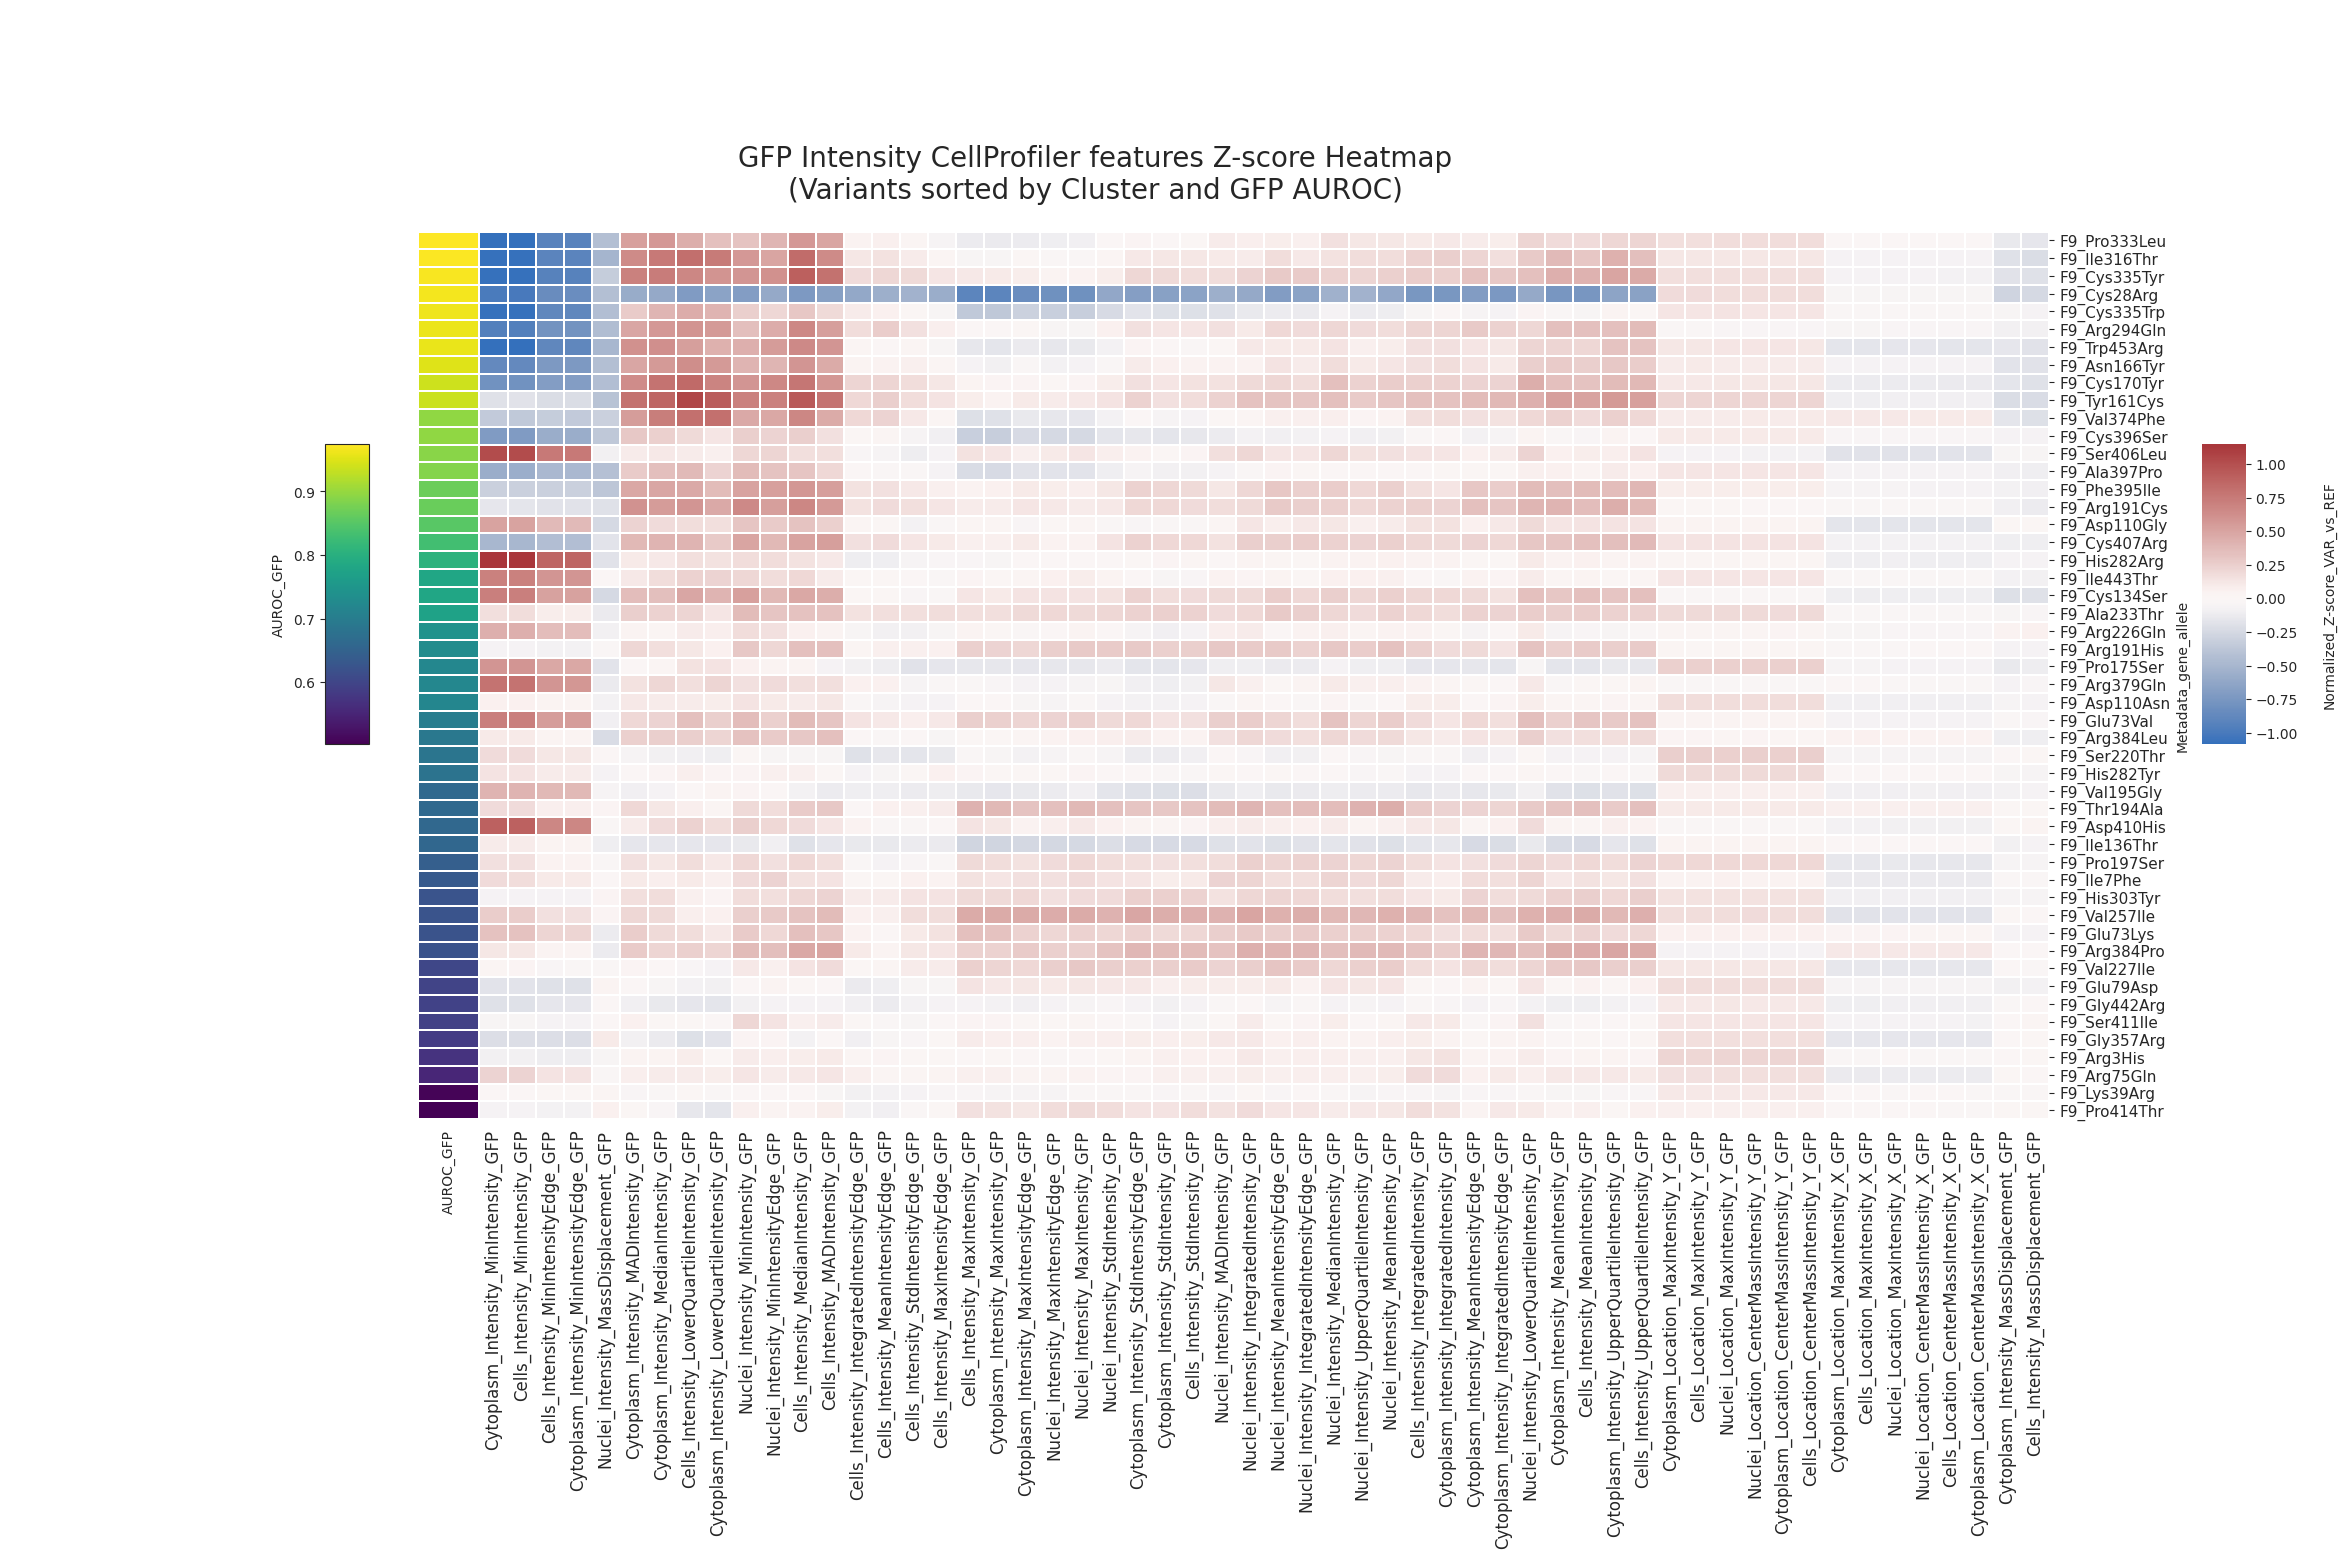

In [108]:
# Create clustermap with cluster-based ordering
g = sns.clustermap(
   data=filtered_df[col_colors_df[col_colors_df["Annotation"]=="forestgreen"].index],
   cmap="vlag", center=0,
   row_colors=row_colors_df,
#    col_colors=col_colors_df,
   row_cluster=False,
   col_cluster=True,
   cbar_pos=(1.003, 0.5, 0.02, 0.2),
   yticklabels=1, xticklabels=1,
   figsize=(22, 15),
   tree_kws={'alpha': 0},  # Make dendrogram invisible
    linewidth=.1,
    colors_ratio=0.03  # Controls row_colors width,
)
# Set tick label sizes
# g.ax_heatmap.tick_params(axis='y', labelsize=10)  # y-axis labels
g.ax_heatmap.tick_params(axis='x', labelsize=12)  # x-axis labels
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90) #, ha='right'
g.fig.suptitle("GFP Intensity CellProfiler features Z-score Heatmap\n(Variants sorted by Cluster and GFP AUROC)", fontsize=20, y=.9)
# Add label to main heatmap colorbar
g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', labelpad=18)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=11) # Adjust fontsize as needed
# Get current ytick labels
ytick_labels = g.ax_heatmap.get_yticklabels()
g.ax_row_colors.tick_params(left=False)
# subset_variants = high_score_mask[high_score_mask].index
# # Color the labels
# for label in ytick_labels:
#    variant_name = label.get_text()
#    if variant_name in subset_variants:
#          label.set_color('red')  # Color for subset members
#    else:
#          label.set_color('black')  # Default color for others

# Add colorbar for AUROC scores
auroc_cbar_ax = g.fig.add_axes([.15, 0.5, 0.02, 0.2])
auroc_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=auroc_cbar_ax)
auroc_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
auroc_cbar.ax.yaxis.set_label_position('left')
auroc_cbar.ax.yaxis.tick_left()

plt.show()

In [18]:
# from matplotlib.colors import Normalize

# # Create aligned datasets with matching shapes
# heatmap_features = [c for c in sig_diff_feat if c in norm_vars_feat_df.columns]
# importance_features = feat_df.select("cp_feature").to_pandas()["cp_feature"].tolist()
# common_features = [f for f in heatmap_features if f in importance_features]

# # heatmap_data = norm_vars_feat_df.to_pandas().set_index("Metadata_gene_allele").loc[sorted_unique_variants, common_features]
# heatmap_data = data_scaled.loc[sorted_unique_variants,:]
# # Create the heatmap data and mask with same dimensions
# # heatmap_data = norm_vars_feat_df.to_pandas().set_index("Metadata_gene_allele").loc[sorted_unique_variants, common_features]
# # importance_data = feat_df.fill_null(0).to_pandas().set_index("cp_feature").loc[common_features, sorted_unique_variants].T

# # Create boolean mask where True values will be masked (shown as light grey)
# # mask = (importance_data == 0) | (importance_data < 0.005)

# # df_with_scores = pd.DataFrame(your_score_array, index=sorted_unique_variants, columns=['AUROC_GFP'])
# # Create a pandas Series with proper index
# row_colors_series = pd.Series(your_score_array, index=sorted_unique_variants, name='AUROC_GFP')

# # Map to colors
# norm = Normalize(vmin=row_colors_series.min(), vmax=row_colors_series.max())
# cmap = plt.cm.viridis
# row_colors = cmap(norm(row_colors_series.values))

# # Create clustermap with custom colorbar positions
# g = sns.clustermap(
#    data=heatmap_data,
# #    mask=mask,
#    cmap="vlag", center=0,
#    row_colors=row_colors,
#     col_cluster=True,
#    cbar_pos=(1.005, 0.47, 0.02, 0.2),  # (left, bottom, width, height) - smaller, center right,
#     yticklabels=1, xticklabels=1,
#     figsize=(14,14),
#     linewidth=.1,
# )
# # Set the background color of the heatmap to light grey
# g.ax_heatmap.set_facecolor('lightgrey')

# # Add label to main heatmap colorbar
# g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', rotation=90, labelpad=15)

# # Add colorbar for row colors on center left
# row_cbar_ax = g.fig.add_axes([.05, 0.47, 0.02, 0.2])  # smaller, center left
# row_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
#                         cax=row_cbar_ax)
# row_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
# row_cbar.ax.yaxis.set_label_position('left')
# row_cbar.ax.yaxis.tick_left()
# plt.show()

In [19]:
# feats = ["Cells_Correlation_RWC_AGP_GFP", "Cytoplasm_Correlation_RWC_DNA_GFP"]
# ref_var_allele = ["F9"]+sorted_unique_variants
# data_for_plot = ref_var_cell_all_prof_df.filter(
#    pl.col("Metadata_gene_allele").is_in(ref_var_allele)
# ).to_pandas()

# fig, axes = plt.subplots(2,1,figsize=(10,6),sharex=True)

# sns.boxplot(
#     data=data_for_plot,
#     x="Metadata_gene_allele",
#     y=feats[0],
#     showfliers=False,
#     order=ref_var_allele,
#     ax=axes[0]
#     # hue="Metadata_gene_allele",
#     # hue_order=sorted(sc_profile_feat_orig.filter(
#     #     pl.col("Metadata_gene_allele").str.contains("BAP1")
#     # )["Metadata_gene_allele"].unique())
# )
# sns.boxplot(
#     data=data_for_plot,
#     x="Metadata_gene_allele",
#     y=feats[1],
#     showfliers=False,
#     order=ref_var_allele,
#     ax=axes[1]
#     # hue="Metadata_gene_allele",
#     # hue_order=sorted(sc_profile_feat_orig.filter(
#     #     pl.col("Metadata_gene_allele").str.contains("BAP1")
#     # )["Metadata_gene_allele"].unique())
# )

# for i, feat in enumerate(feats):
#     # Add mean points
#     means = data_for_plot.groupby("Metadata_gene_allele")[feat].mean()
#     for j, allele in enumerate(ref_var_allele):
#        axes[i].scatter(j, means[allele], color='red', s=25, marker='D', zorder=10)
#     axes[i].axhline(means["F9"], linewidth=1, color="tomato", linestyle="--")
#     axes[i].grid(alpha=.2)
#     axes[i].set_ylabel(feat, fontsize=8)
        
# # ax.set_yscale("log")
# axes[1].set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
# plt.subplots_adjust(hspace=.02)
# plt.show()

In [66]:
norm_vars_feat_meta_df = pl.DataFrame(norm_vars_feat_df).join(
    imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele"),
    left_on="Metadata_gene_allele",
    right_on="gene_allele"
).rename(
    dict(
        zip(
            [c for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_allele"],
            [f"Metadata_{c}" for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_allele"]
        )
    )
)
norm_vars_feat_meta_df.shape

(50, 1263)

In [80]:
from sklearn.decomposition import PCA
from functools import reduce
from pycytominer.feature_select import feature_select
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
import networkx as nx
import community.community_louvain as community_louvain
import umap

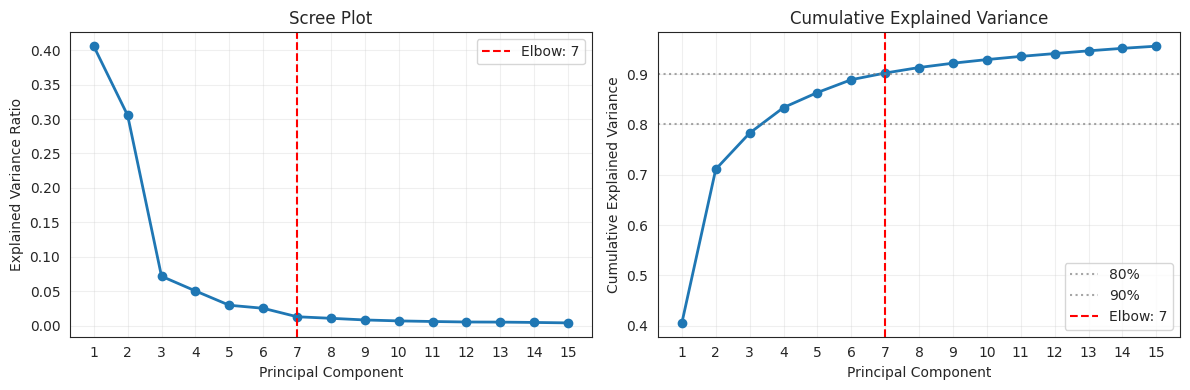

Optimal components: 7
Explained variance at elbow: 90.2%


In [81]:
# Fit PCA with all components
feature_cols = [c for c in norm_vars_feat_meta_df.columns if "Metadata" not in c]

pca_full = PCA()
pca_full.fit(norm_vars_feat_meta_df.select(feature_cols).to_numpy())

# Calculate variances
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

from kneed import KneeLocator
# Find elbow point using KneeLocator
knee_locator = KneeLocator(
    range(1, len(explained_variance_ratio)+1),
    explained_variance_ratio,
    curve='convex',
    direction='decreasing'
)
optimal_components = knee_locator.knee

# explained_var_thres = 0.6
# cumvar = np.cumsum(pca_full.explained_variance_ratio_)
# optimal_components = np.argmax(cumvar >= explained_var_thres) + 1

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot
n_show = min(15, len(explained_variance_ratio))
ax1.plot(range(1, n_show + 1), explained_variance_ratio[:n_show], 'o-', linewidth=2)
ax1.axvline(x=optimal_components, color='red', linestyle='--', label=f'Elbow: {optimal_components}')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot')
ax1.set_xticks(range(1, n_show + 1))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative variance plot
ax2.plot(range(1, n_show + 1), cumulative_variance[:n_show], 'o-', linewidth=2)
ax2.axhline(y=0.8, color='gray', linestyle=':', alpha=0.7, label='80%')
ax2.axhline(y=0.9, color='gray', linestyle=':', alpha=0.7, label='90%')
ax2.axvline(x=optimal_components, color='red', linestyle='--', label=f'Elbow: {optimal_components}')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xticks(range(1, n_show + 1))
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results
print(f"Optimal components: {optimal_components}")
print(f"Explained variance at elbow: {cumulative_variance[optimal_components-1]:.1%}")

# Apply optimal PCA
pca = PCA(n_components=optimal_components)
data_pca = pca.fit_transform(norm_vars_feat_meta_df.select(feature_cols).to_numpy())

In [82]:
# UMAP plot
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1) ## metric='cosine', 
umap_embedding = reducer.fit_transform(data_pca)

/home/shenrunx/software/anaconda3/envs/varchamp/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [83]:
# Generate k-NN graph
k = 10  # adjust based on testing
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine')
nbrs.fit(data_pca)
distances, indices = nbrs.kneighbors(data_pca)

# Build unweighted graph
G = nx.Graph()
for i in range(len(data_pca)):
    for j in indices[i][1:]:  # skip self
        G.add_edge(i, j)

# Louvain clustering
cluster_dict = community_louvain.best_partition(G) # , resolution=2

In [84]:
dr_res_df = pd.DataFrame(
    data_pca,
    columns=[f"PC{i}" for i in range(1, data_pca.shape[1]+1)]
)
dr_res_df = pd.concat([
    dr_res_df,
    pd.DataFrame(umap_embedding, 
                 columns=["UMAP1", "UMAP2"])
    ],
    axis=1
)
dr_res_df["cluster"] = dr_res_df.index.map(cluster_dict)
dr_res_df["Metadata_AUROC_Mean_GFP"] = norm_vars_feat_meta_df["Metadata_AUROC_Mean_GFP"]
dr_res_df["Metadata_GFP_corrected_mean_AUROC"] = norm_vars_feat_meta_df["Metadata_GFP_corrected_mean_AUROC"] 
dr_res_df["Metadata_Altered_95th_perc_both_batches_GFP"] = norm_vars_feat_meta_df["Metadata_Altered_95th_perc_both_batches_GFP"]
dr_res_df.index = norm_vars_feat_meta_df["Metadata_gene_allele"]

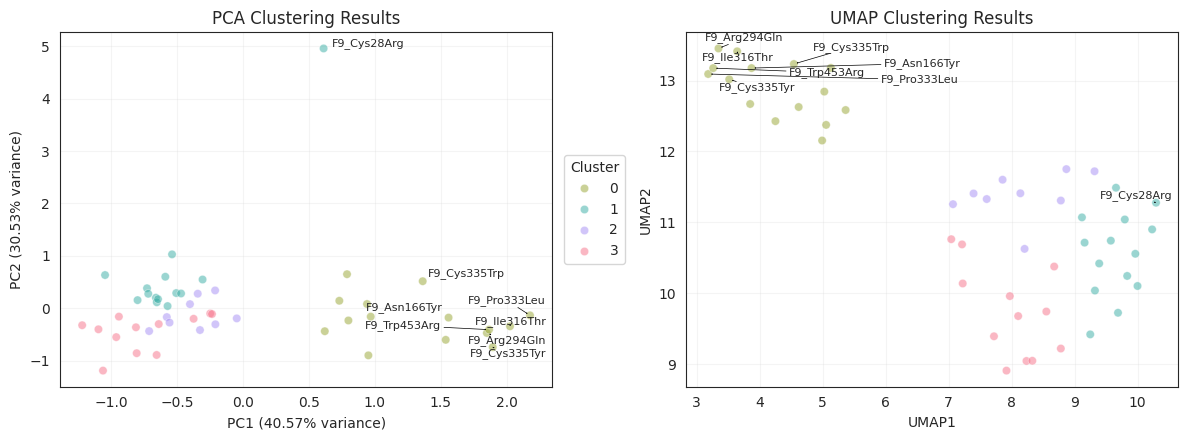

In [85]:
# Get unique clusters and create color palette
n_clusters = len(np.unique(dr_res_df["cluster"]))
colors = sns.color_palette("husl", n_clusters)
color_map = {cluster: colors[i] for i, cluster in enumerate(dr_res_df["cluster"].unique())}
auroc_thres = 0.95

fig, ax = plt.subplots(1,2, figsize=(12, 4.5))
# PCA plot
sns.scatterplot(
    dr_res_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette=color_map,
    ax=ax[0],
    alpha=.5,
    # legend=False
)
# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax[0].set_title('PCA Clustering Results')
ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', title="Cluster", ncol=1)

# PCA plot
sns.scatterplot(
    dr_res_df,
    x="UMAP1",
    y="UMAP2",
    hue="cluster",
    palette=color_map,
    ax=ax[1],
    alpha=.5,
    legend=False
)
# Add text labels for high-scoring points in PCA
high_score_mask = dr_res_df['Metadata_GFP_corrected_mean_AUROC'] >= auroc_thres
# ax[1].get_legend().remove()

texts_pca = []
for idx in dr_res_df[high_score_mask].index:
   texts_pca.append(ax[0].text(
       dr_res_df.loc[idx, 'PC1'],
       dr_res_df.loc[idx, 'PC2'],
       str(idx),
       fontsize=8
   ))
adjust_text(texts_pca, ax=ax[0], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Add text labels for high-scoring points in UMAP
texts_umap = []
for idx in dr_res_df[high_score_mask].index:
   texts_umap.append(ax[1].text(
       dr_res_df.loc[idx, 'UMAP1'],
       dr_res_df.loc[idx, 'UMAP2'],
       str(idx),
       fontsize=8
   ))
adjust_text(texts_umap, ax=ax[1], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))


# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[1].scatter(embedding[mask, 0], embedding[mask, 1],
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)

ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('UMAP Clustering Results')

ax[0].grid(alpha=.2)
ax[1].grid(alpha=.2)
plt.subplots_adjust(wspace=.3)
plt.tight_layout()
plt.show()

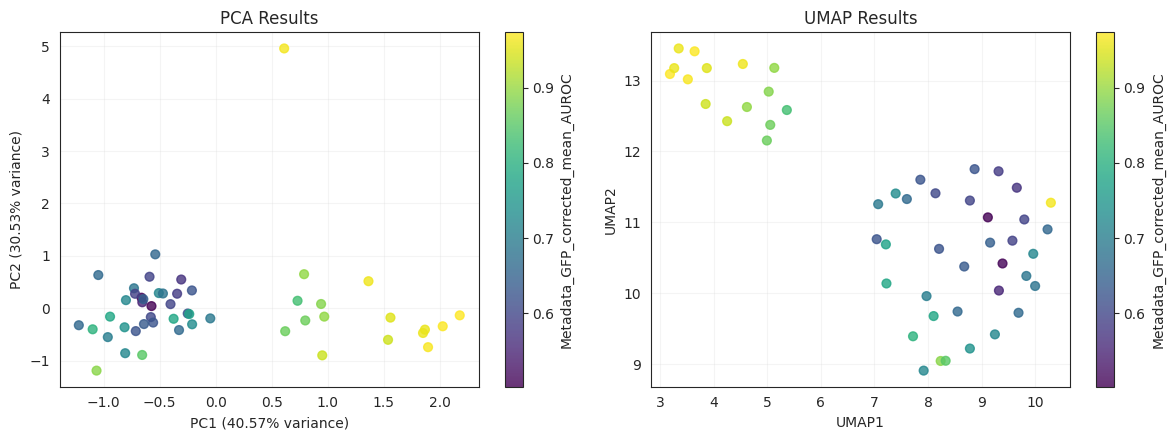

In [86]:
# Assuming your continuous score column is named 'score' in dr_res_df
# If it has a different name, replace 'score' with your column name

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

# Create normalization and colormap for continuous scores
norm = Normalize(vmin=dr_res_df['Metadata_GFP_corrected_mean_AUROC'].min(), vmax=dr_res_df['Metadata_GFP_corrected_mean_AUROC'].max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

# PCA plot with continuous coloring
scatter1 = ax[0].scatter(
    dr_res_df['PC1'],
    dr_res_df['PC2'],
    c=dr_res_df['Metadata_GFP_corrected_mean_AUROC'],
    cmap=cmap,
    alpha=0.8,
    s=40
)
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax[0].set_title('PCA Results')
plt.colorbar(scatter1, ax=ax[0], label='Metadata_GFP_corrected_mean_AUROC')

# UMAP plot with continuous coloring
scatter2 = ax[1].scatter(
    dr_res_df['UMAP1'],
    dr_res_df['UMAP2'],
    c=dr_res_df['Metadata_GFP_corrected_mean_AUROC'],
    cmap=cmap,
    alpha=0.8,
    s=40,
)
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('UMAP Results')
plt.colorbar(scatter2, ax=ax[1], label='Metadata_GFP_corrected_mean_AUROC')

ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
plt.tight_layout()
plt.show()

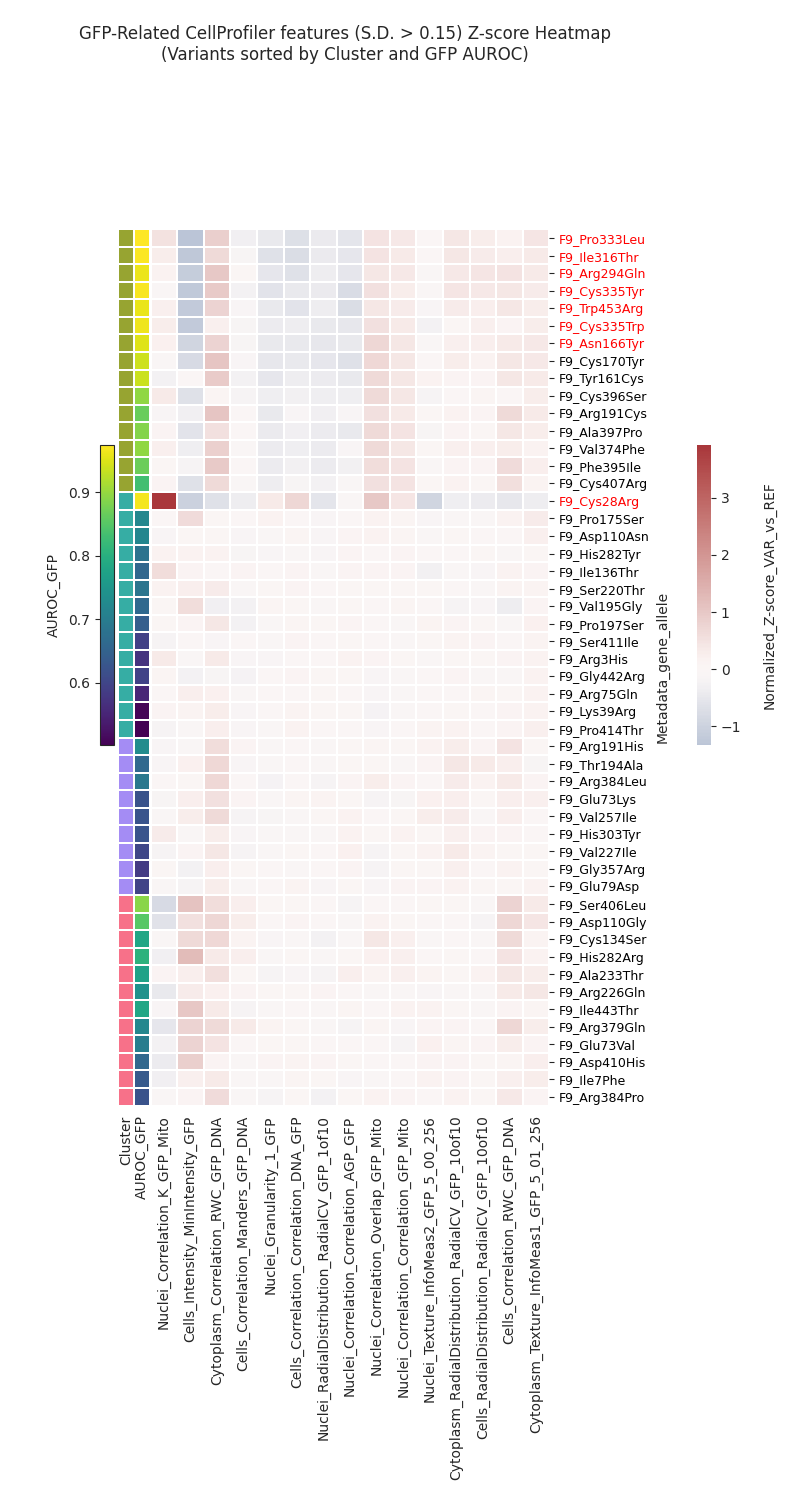

In [87]:
# Get cluster order from UMAP clustering
cluster_order = dr_res_df.sort_values('cluster')['cluster'].unique()

# Create cluster color mapping
n_clusters = len(np.unique(dr_res_df["cluster"]))
cluster_colors = sns.color_palette("husl", n_clusters)
cluster_color_map = {cluster: cluster_colors[i] for i, cluster in enumerate(dr_res_df["cluster"].unique())}

# Create ordered list based on clusters, then by score within clusters
ordered_variants = []
cluster_labels = []
for cluster in cluster_order:
   cluster_variants = dr_res_df[dr_res_df['cluster'] == cluster].sort_values('Metadata_AUROC_Mean_GFP', ascending=False).index.tolist()
   ordered_variants.extend(cluster_variants)
   cluster_labels.extend([cluster] * len(cluster_variants))

# Filter to only variants present in both datasets
available_variants = []
available_cluster_labels = []
for i, variant in enumerate(ordered_variants):
   if variant in sorted_unique_variants:
       available_variants.append(variant)
       available_cluster_labels.append(cluster_labels[i])

# Get scores for the ordered variants
ordered_scores = []
for variant in available_variants:
   score = norm_vars_feat_meta_df.filter(pl.col("Metadata_gene_allele") == variant)["Metadata_GFP_corrected_mean_AUROC"].item()
   ordered_scores.append(score)

ordered_scores_array = np.array(ordered_scores)

# Create row colors - AUROC scores
auroc_colors_series = pd.Series(ordered_scores_array, index=available_variants, name='AUROC_GFP')
norm = Normalize(vmin=auroc_colors_series.min(), vmax=auroc_colors_series.max())
cmap = plt.cm.viridis
auroc_colors = cmap(norm(auroc_colors_series.values))

# Create cluster colors array - convert RGBA tuples to arrays
cluster_colors_array = np.array([cluster_color_map[cluster] for cluster in available_cluster_labels])

# Combine both color arrays as separate columns
row_colors_df = pd.DataFrame(index=available_variants)
row_colors_df['Cluster'] = [cluster_color_map[cluster] for cluster in available_cluster_labels]
row_colors_df['AUROC_GFP'] = list(auroc_colors)

df = norm_vars_feat_meta_df.to_pandas().set_index("Metadata_gene_allele").loc[available_variants, [c for c in norm_vars_feat_meta_df.columns if "Metadata" not in c]] ## [c for c in get_top_feats if c in norm_vars_feat_meta_df.columns]
filtered_df = df.loc[:,  (df.std() > 0.15)] ##(df.abs().mean() > 0.1) &
# Create clustermap with cluster-based ordering
g = sns.clustermap(
   data=filtered_df,
   cmap="vlag", center=0,
   row_colors=row_colors_df,
   row_cluster=False,
   cbar_pos=(1.003, 0.5, 0.02, 0.2),
   yticklabels=1, xticklabels=1,
   figsize=(7, 15),
   tree_kws={'alpha': 0},  # Make dendrogram invisible
    linewidth=.1,
    colors_ratio=0.03  # Controls row_colors width,
)
# Set tick label sizes
# g.ax_heatmap.tick_params(axis='y', labelsize=10)  # y-axis labels
g.ax_heatmap.tick_params(axis='x', labelsize=10)  # x-axis labels
g.fig.suptitle("GFP-Related CellProfiler features (S.D. > 0.15) Z-score Heatmap\n(Variants sorted by Cluster and GFP AUROC)", fontsize=12, y=.98)
# Add label to main heatmap colorbar
g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', rotation=90, labelpad=15)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=9) # Adjust fontsize as needed
# Get current ytick labels
ytick_labels = g.ax_heatmap.get_yticklabels()
subset_variants = high_score_mask[high_score_mask].index
# Color the labels
for label in ytick_labels:
   variant_name = label.get_text()
   if variant_name in subset_variants:
         label.set_color('red')  # Color for subset members
   else:
         label.set_color('black')  # Default color for others

# Add colorbar for AUROC scores
auroc_cbar_ax = g.fig.add_axes([.15, 0.5, 0.02, 0.2])
auroc_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=auroc_cbar_ax)
auroc_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
auroc_cbar.ax.yaxis.set_label_position('left')
auroc_cbar.ax.yaxis.tick_left()

plt.show()

In [20]:
# sns.histplot(
#     data=df.std(),
#     binwidth=.05
# )
# plt.show()

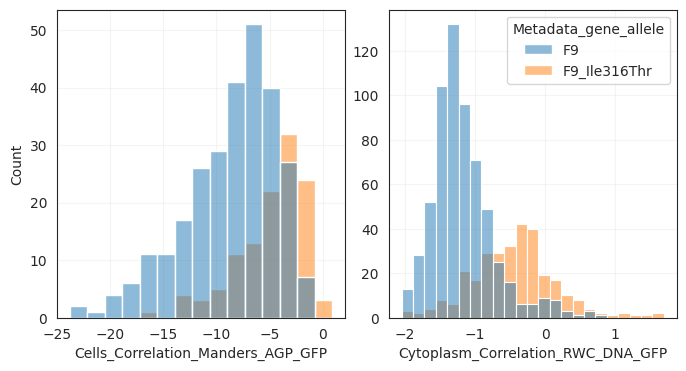

In [59]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.histplot(
    data=ref_var_cell_all_prof_df.filter(
        pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Ile316")
    ).to_pandas(),
    x="Cells_Correlation_Manders_AGP_GFP", #"Cytoplasm_Correlation_RWC_DNA_GFP"
    hue="Metadata_gene_allele",
    ax=axes[0]
)
sns.histplot(
    data=ref_var_cell_all_prof_df.filter(
        pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Ile316")
    ).to_pandas(),
    x="Cytoplasm_Correlation_RWC_DNA_GFP",
    hue="Metadata_gene_allele",
    ax=axes[1]
)
axes[0].get_legend().remove()
axes[0].grid(alpha=.2)

axes[1].grid(alpha=.2)
axes[1].set_ylabel("")
plt.subplots_adjust(wspace=.15)
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(8,4))
sns.regplot(
    data=ref_var_cell_all_prof_df.filter(
        pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Cys28")
    ).to_pandas(),
    x="Cells_Correlation_Manders_AGP_GFP", #"Cytoplasm_Correlation_RWC_DNA_GFP"
    hue="Metadata_gene_allele",
    ax=axes[0]
)
sns.histplot(
    data=ref_var_cell_all_prof_df.filter(
        pl.col("Metadata_refvar_gfp_adj_classify").str.contains("F9_Cys28")
    ).to_pandas(),
    x="Cytoplasm_Correlation_RWC_DNA_GFP",
    hue="Metadata_gene_allele",
    ax=axes[1]
)
axes[0].get_legend().remove()
axes[0].grid(alpha=.2)

axes[1].grid(alpha=.2)
axes[1].set_ylabel("")
plt.subplots_adjust(wspace=.15)
plt.show()

In [ ]:
imaging_summary_clinvar_pillar_snp_match_df_gene[""]

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_both_batches_Morph,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,symbol,ensembl_gene_id,orf_id,mut_id,…,spliceAI_DP_DL,Segregation LR_PMID:31131967,Pathology LR_PMID:31131967,Co-occurrence LR_PMID:31131967,Family History LR_PMID:31131967,Combined LR (Odds for Causality)_PMID:31131967,Prior Probability of Pathogenicity_PMID:31131967,Comment regarding class assignment_PMID:31131967,IARC Class_PMID:31131967,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,allele_1,GFP_corrected_mean_AUROC,GFP_corrected_mean_AUPRC
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,bool,str,str,i64,f64,…,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,str,f64,f64
"""F9""","""F9_Ala233Thr""",-0.770544,0.466183,3.587645,0.008885,"""2025_01_Batch_13-14""",0.702375,0.760666,0.712567,0.696976,0.632236,0.854004,0.881267,0.825097,0.891183,0.609202,0.77819,0.820966,0.768832,0.794079,0.620719,false,false,false,false,false,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,26.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Ala233Thr""","""Ala233Thr""",true,"""F9""",0.774084,0.783529
"""F9""","""F9_Ala233Thr""",-0.770544,0.466183,3.587645,0.008885,"""2025_01_Batch_13-14""",0.702375,0.760666,0.712567,0.696976,0.632236,0.854004,0.881267,0.825097,0.891183,0.609202,0.77819,0.820966,0.768832,0.794079,0.620719,false,false,false,false,false,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,26.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Ala233Thr""","""Ala233Thr""",true,"""F9""",0.774084,0.783529
"""F9""","""F9_Ala233Thr""",-0.770544,0.466183,3.587645,0.008885,"""2025_01_Batch_13-14""",0.702375,0.760666,0.712567,0.696976,0.632236,0.854004,0.881267,0.825097,0.891183,0.609202,0.77819,0.820966,0.768832,0.794079,0.620719,false,false,false,false,false,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,26.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Ala233Thr""","""Ala233Thr""",true,"""F9""",0.774084,0.783529
"""F9""","""F9_Ala233Thr""",-0.770544,0.466183,3.587645,0.008885,"""2025_01_Batch_13-14""",0.702375,0.760666,0.712567,0.696976,0.632236,0.854004,0.881267,0.825097,0.891183,0.609202,0.77819,0.820966,0.768832,0.794079,0.620719,false,false,false,false,false,0.0,0.0,0.0,0.0,0.0,true,"""F9""",null,52861,null,…,26.0,null,

## 4. Protein features

In [15]:
f9_struc = pl.read_csv(
    "../../../../1_allele_collection/1_inputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv", 
    separator="\t", infer_schema_length=10000000
)
f9_struc = f9_struc.filter(pl.col("symbol")=="F9")
f9_prot_feat_df = pl.read_csv("../../../../1_allele_collection/1_inputs/G2P_F9_P00740_protein_features.tsv", separator="\t")

In [16]:
sys.path.append("../../../../1_allele_collection/1_inputs")
from g2p import *
from amino_acid_metrics import *

ccm2_genome2protein_feat_file = "../../../../1_allele_collection/1_inputs/G2P_F9_P00740_protein_features.tsv"
validate_variants_against_protein_features(imaging_summary_clinvar_pillar_snp_match_df_gene.to_pandas(), ccm2_genome2protein_feat_file)
imaging_summary_prot_df = extract_protein_features_for_variants(imaging_summary_clinvar_pillar_snp_match_df_gene.to_pandas(), ccm2_genome2protein_feat_file)
imaging_summary_prot_df = pl.DataFrame(imaging_summary_prot_df).join(
    f9_struc.select(["gene_variant","plddt","rsa"]),
    left_on="gene_allele",
    right_on="gene_variant",
    how="inner"
)

df_with_metrics = add_amino_acid_metrics(imaging_summary_prot_df)
df_with_metrics = df_with_metrics.to_pandas()
aa_diff_cols = [c for c in df_with_metrics.columns if c not in imaging_summary_prot_df.columns]

  ✓ Added 78 protein feature columns


In [17]:
aa_diff_cols

['aa_original',
 'aa_new',
 'aa_position',
 'blosum62_score',
 'pam250_score',
 'miyata_distance',
 'grantham_distance',
 'hydrophobicity_diff',
 'molecular_weight_diff',
 'charge_diff',
 'helix_propensity_diff',
 'volume_diff',
 'polarity_diff',
 'chemical_group_change',
 'aa_severity_score',
 'is_conservative',
 'is_radical']

In [50]:
df_with_metrics[df_with_metrics["protein_Signal (UniProt)"]=="Signal"].drop_duplicates(
    "gene_allele"
).sort_values("GFP_corrected_mean_AUROC", ascending=False)[["gene_allele","GFP_corrected_mean_AUROC","plddt","rsa"]+["aa_severity_score","blosum62_score","pam250_score","miyata_distance","hydrophobicity_diff"]]#.set_index("gene_allele").to_dict()

,gene_allele,GFP_corrected_mean_AUROC,plddt,rsa,aa_severity_score,blosum62_score,pam250_score,miyata_distance,hydrophobicity_diff
174,F9_Cys28Arg,0.965787,60.23,0.829630,0.641517,-3.0,-4.0,60.606600,7.0
324,F9_Ile7Phe,0.634161,38.98,0.781065,0.277500,0.0,1.0,22.000000,1.7
96,F9_Arg3His,0.571010,34.00,0.971774,0.245000,0.0,2.0,26.000192,1.3


In [27]:
# sns.regplot(
#     data=imaging_summary_prot_df[imaging_summary_prot_df["protein_Domain (UniProt)"]=="Peptidase S1"].drop_duplicates(
#         "gene_allele"
#     ),
#     x="GFP_corrected_mean_AUROC",
#     y="plddt",
# )
# plt.show()
# sns.regplot(
#     data=imaging_summary_prot_df[imaging_summary_prot_df["protein_Domain (UniProt)"]=="Peptidase S1"].drop_duplicates(
#         "gene_allele"
#     ),
#     x="GFP_corrected_mean_AUROC",
#     y="rsa",
# )
# plt.show()

In [51]:
df_with_metrics[df_with_metrics["protein_Domain (UniProt)"]=="EGF-like 2"].drop_duplicates(
    "gene_allele"
).sort_values("GFP_corrected_mean_AUROC", ascending=False)[
    ["gene_allele","GFP_corrected_mean_AUROC","plddt","rsa"]+["aa_severity_score","blosum62_score","molecular_weight_diff","pam250_score","miyata_distance","hydrophobicity_diff"]
]#.set_index("gene_allele").to_dict()

,gene_allele,GFP_corrected_mean_AUROC,plddt,rsa,aa_severity_score,blosum62_score,molecular_weight_diff,pam250_score,miyata_distance,hydrophobicity_diff
108,F9_Asn166Tyr,0.950478,90.75,0.535032,0.422121,-2.0,49.0706,-2.0,58.848279,2.2
162,F9_Cys170Tyr,0.937850,95.58,0.044444,0.496758,-2.0,60.0303,0.0,72.703370,3.8
426,F9_Tyr161Cys,0.936112,95.80,0.108108,0.496758,-2.0,60.0303,0.0,72.703370,3.8
156,F9_Cys134Ser,0.781061,85.56,0.140741,0.321853,-1.0,16.0656,0.0,15.741029,3.3
306,F9_Ile136Thr,0.656931,78.46,0.372781,0.435842,-1.0,12.0537,0.0,42.336745,5.2


In [46]:
df_with_metrics[df_with_metrics["protein_Domain (UniProt)"]=="Peptidase S1"].drop_duplicates(
    "gene_allele"
).sort_values("GFP_corrected_mean_AUROC", ascending=False)[
    ["gene_allele","GFP_corrected_mean_AUROC","plddt","rsa"]+["blosum62_score","molecular_weight_diff","pam250_score","miyata_distance","hydrophobicity_diff","aa_severity_score"]
]

,gene_allele,GFP_corrected_mean_AUROC,plddt,rsa,blosum62_score,molecular_weight_diff,pam250_score,miyata_distance,hydrophobicity_diff,aa_severity_score
354,F9_Pro333Leu,0.974087,97.66,0.095588,-3.0,16.0424,-3.0,51.693036,5.4,0.404233
312,F9_Ile316Thr,0.971232,97.70,0.000000,-1.0,12.0537,0.0,42.336745,5.2,0.435842
192,F9_Cys335Tyr,0.969907,96.87,0.007407,-2.0,60.0303,0.0,72.703370,3.8,0.496758
186,F9_Cys335Trp,0.962275,96.87,0.007407,-2.0,83.0670,-8.0,100.900050,3.4,0.555000
48,F9_Arg294Gln,0.959791,97.66,0.129032,1.0,28.0565,1.0,24.300000,1.0,0.320750
414,F9_Trp453Arg,0.957587,97.31,0.096916,-3.0,30.0242,2.0,40.819848,3.6,0.507050
450,F9_Val374Phe,0.896508,91.21,0.000000,-1.0,48.0428,-1.0,44.005568,1.4,0.345014
198,F9_Cys396Ser,0.896376,93.62,0.007407,-1.0,16.0656,0.0,15.741029,3.3,0.321853
384,F9_Ser406Leu,0.889922,60.89,0.115385,-2.0,26.0803,-3.0,64.343842,4.6,0.495860
6,F9_Ala397Pro,0.887151,92.51,0.000000,-1.0,26.0373,1.0,14.400347,3.4,0.221001


In [24]:
df_with_metrics.drop_duplicates("gene_allele")[["gene_allele","rsa","GFP_corrected_mean_AUROC"]].to_csv("F9.csv")

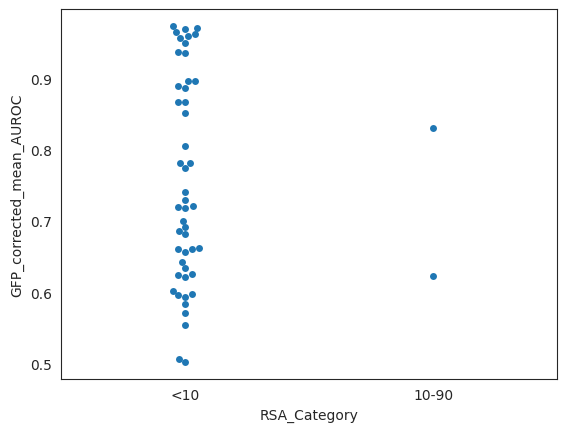

In [18]:
sns.swarmplot(
    data=pl.DataFrame(df_with_metrics).with_columns(
        pl.when(pl.col("rsa")<10)
        .then(pl.lit("<10"))
        .when(pl.col("rsa")>90)
        .then(pl.lit(">90"))
        .otherwise(pl.lit("10-90"))
        .alias("RSA_Category")
    ).unique("gene_allele").to_pandas(),#,[df_with_metrics["protein_Domain (UniProt)"]=="Peptidase S1"],
    y="GFP_corrected_mean_AUROC",
    x="RSA_Category"
)
plt.show()

<ipython-input-52-d92e2cd421a2>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right')


<Figure size 640x480 with 0 Axes>

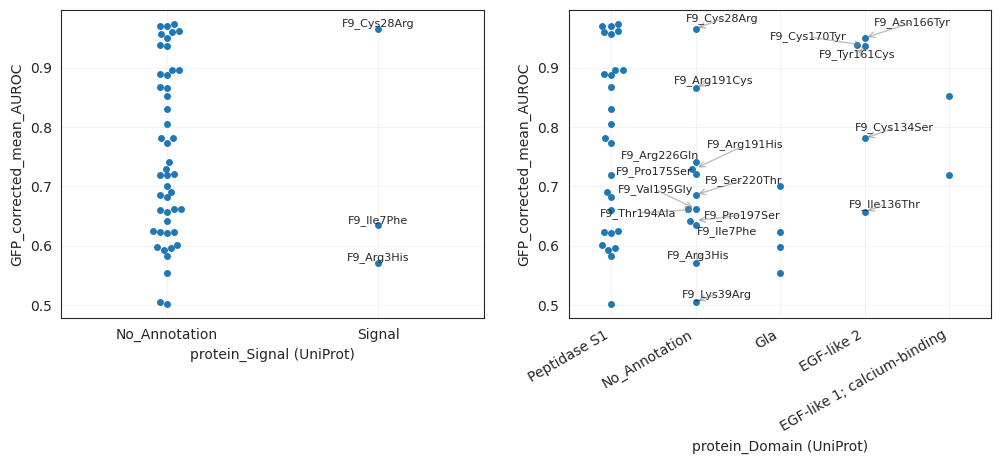

In [52]:
df_with_metrics = df_with_metrics.replace("", "No_Annotation")

from adjustText import adjust_text

plt.clf()
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.swarmplot(
    data=df_with_metrics.drop_duplicates("gene_allele"),
    x='protein_Signal (UniProt)',
    y="GFP_corrected_mean_AUROC",
    ax=axes[0]
)
# Label each point on axes[0]
for i, row in df_with_metrics[df_with_metrics["protein_Signal (UniProt)"]=="Signal"].drop_duplicates("gene_allele").iterrows():
    axes[0].text(
        row['protein_Signal (UniProt)'],
        row['GFP_corrected_mean_AUROC'],
        str(row['gene_allele']),
        ha='center', va='bottom', fontsize=8
    )
    

sns.swarmplot(
    data=df_with_metrics.drop_duplicates("gene_allele"),
    x='protein_Domain (UniProt)',
    y="GFP_corrected_mean_AUROC",
    ax=axes[1]
)
text1 = []
# Label each point on axes[0]
for i, row in df_with_metrics[(df_with_metrics["protein_Domain (UniProt)"]=="EGF-like 2")|(df_with_metrics["protein_Domain (UniProt)"]=="No_Annotation")].drop_duplicates("gene_allele").iterrows():
    text1.append(
        axes[1].text(
            row['protein_Domain (UniProt)'],
            row['GFP_corrected_mean_AUROC'],
            str(row['gene_allele']),
            ha='center', va='bottom', fontsize=8
        )
    )
adjust_text(text1, ax=axes[1], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5), expand_text=(1.2,1.4), expand_points=(1.2,1.4), force_text=(0.5,0.5), force_points=(0.5,0.5), lim=200)

axes[1].tick_params(axis='x', labelrotation=30)
axes[1].set_xticklabels(axes[1].get_xticklabels(), ha='right')
axes[0].grid(alpha=.2)
axes[1].grid(alpha=.2)
plt.show()

In [45]:
df_with_metrics[df_with_metrics["protein_Domain (UniProt)"]=="No_Annotation"].drop_duplicates("gene_allele")

,Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,...,hydrophobicity_diff,molecular_weight_diff,charge_diff,helix_propensity_diff,volume_diff,polarity_diff,chemical_group_change,aa_severity_score,is_conservative,is_radical
18,F9,F9_Arg191Cys,-3.114090,0.020740,4.191694,0.004077,2025_01_Batch_13-14,0.829494,0.771305,0.904936,...,7.0,53.0428,1.0,0.28,60.4,5.0,1.0,0.641517,0.0,1.0
24,F9,F9_Arg191His,-2.575192,0.036729,2.942358,0.021641,2025_01_Batch_13-14,0.665139,0.729760,0.718484,...,1.3,19.0464,0.9,0.02,26.0,0.1,0.0,0.245000,0.0,0.0
36,F9,F9_Arg226Gln,-1.700813,0.132772,1.455627,0.188831,2025_01_Batch_13-14,0.660295,0.761984,0.777831,...,1.0,28.0565,1.0,0.13,24.3,0.0,1.0,0.320750,1.0,0.0
96,F9,F9_Arg3His,-0.664627,0.527569,0.899110,0.398466,2025_01_Batch_13-14,0.619048,0.632278,0.561423,...,1.3,19.0464,0.9,0.02,26.0,0.1,0.0,0.245000,0.0,0.0
174,F9,F9_Cys28Arg,2.152585,0.068352,-15.200295,0.000001,2025_01_Batch_13-14,0.627701,0.659188,0.978544,...,7.0,53.0428,1.0,0.28,60.4,5.0,1.0,0.641517,0.0,1.0
324,F9,F9_Ile7Phe,-1.879892,0.102182,2.028126,0.082140,2025_01_Batch_13-14,0.665877,0.588444,0.680416,...,1.7,34.0162,0.0,0.05,22.0,0.0,1.0,0.277500,0.0,0.0
330,F9,F9_Lys39Arg,0.583415,0.577919,0.198495,0.848300,2025_01_Batch_13-14,0.528013,0.450257,0.461066,...,0.6,28.0134,0.0,0.18,5.0,0.8,0.0,0.067659,1.0,0.0
342,F9,F9_Pro175Ser,0.523976,0.616471,-1.822338,0.111187,2025_01_Batch_13-14,0.709909,0.718682,0.730005,...,0.8,10.0379,0.0,0.20,12.6,1.2,1.0,0.251643,0.0,0.0
348,F9,F9_Pro197Ser,-3.077589,0.017876,3.393971,0.011537,2025_01_Batch_13-14,0.617039,0.601584,0.710834,...,0.8,10.0379,0.0,0.20,12.6,1.2,1.0,0.251643,0.0,0.0
378,F9,F9_Ser220Thr,-1.581368,0.157807,-0.427971,0.681531,2025_01_Batch_13-14,0.782719,0.770262,0.694897,...,0.1,14.0266,0.0,0.06,22.0,0.6,0.0,0.117520,1.0,0.0
